# Purity/Efficiency Plot of the SPANet Resolved Output

In [1]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/envs/phys239/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [21]:
# read test target file
test_file = "//Users/billyli/UCSD/hhh/reports/bv2/hhh_test.h5"
test_h5 = h5.File(test_file)

# read baseline prediction
baseline_file = "//Users/billyli/UCSD/hhh/reports/bv2/pred_baseline.h5"
b_h5 = h5.File(baseline_file)

# read spanet prediction
spanet_file = "//Users/billyli/UCSD/hhh/reports/bv2/dp_on/pred_v53.h5"
s_h5 = h5.File(spanet_file)

# read spanet prediction
pb_off_file = "//Users/billyli/UCSD/hhh/reports/bv2/pb_off_pred_v61.h5"
pb_h5 = h5.File(pb_off_file)

In [3]:
test_h5['TARGETS'].keys()

<KeysViewHDF5 ['bh1', 'bh2', 'bh3', 'h1', 'h2', 'h3']>

In [4]:
def sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=0.0, ap_cut=0):
    # parse predicted bb assignment by DP
    dp_filter = dps > dp_cut
    ap_filter = aps > ap_cut
    b1_ak4_filter = b1_ps<10
    b2_ak4_filter = b2_ps<10
    filter = dp_filter & ap_filter & b1_ak4_filter & b2_ak4_filter
    
    b1_ps_passed = b1_ps.mask[filter]
    b1_ps_passed = ak.drop_none(b1_ps_passed)
    
    b2_ps_passed = b2_ps.mask[filter]
    b2_ps_passed = ak.drop_none(b2_ps_passed)
    
    return b1_ps_passed, b2_ps_passed

In [5]:
def sel_target_h_by_mask(b1_ts, b2_ts, h_pts, h_masks):
    b1_ts_selected = b1_ts.mask[h_masks]
    b1_ts_selected = ak.drop_none(b1_ts_selected)
    
    b2_ts_selected = b2_ts.mask[h_masks]
    b2_ts_selected = ak.drop_none(b2_ts_selected)
    
    h_selected_pts = h_pts.mask[h_masks]
    h_selected_pts = ak.drop_none(h_selected_pts)
    
    return b1_ts_selected, b2_ts_selected, h_selected_pts

In [6]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct, pred_H_pt, pred_b1, pred_b2]]
@nb.njit
def gen_pred_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, jets_e, goodJetIdx_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        builder.begin_list()
        for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
            correct = 0
            predH_pt = (jets_e[b1_p]+jets_e[b2_p]).pt
            for b1_t, b2_t in zip(b1_ts_e, b2_ts_e):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)) and (b1_p in goodJetIdx_e) and (b2_p in goodJetIdx_e):
                    correct = 1
            builder.begin_list()
            builder.append(correct)
            builder.append(predH_pt)
            builder.append(b1_p)
            builder.append(b2_p)
            builder.end_list()
        
        builder.end_list()
    return builder

In [7]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt, target_b1, target_b2]]
@nb.njit
def gen_target_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, tH_pts_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        builder.begin_list()
        for b1_t, b2_t, tH_pt in zip(b1_ts_e, b2_ts_e, tH_pts_e):
            retrieved = 0
            for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)):
                    retrieved = 1
            builder.begin_list()
            builder.append(retrieved)
            builder.append(tH_pt)
            builder.append(b1_t)
            builder.append(b2_t)
            builder.end_list()
        
        builder.end_list()
    return builder

In [8]:
def parse_resolved_w_target(testfile, predfile, dp_cut=0.5, fjs_reco=None):
    # h pt
    h1_pt = np.array(testfile['TARGETS']['h1']['pt'])
    h2_pt = np.array(testfile['TARGETS']['h2']['pt'])
    h3_pt = np.array(testfile['TARGETS']['h3']['pt'])
    
    # mask
    h1_mask = np.array(testfile['TARGETS']['h1']['mask'])
    h2_mask = np.array(testfile['TARGETS']['h2']['mask'])
    h3_mask = np.array(testfile['TARGETS']['h3']['mask'])
    
    # target assignments
    b1_h1_t = np.array(testfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_t = np.array(testfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_t = np.array(testfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_t = np.array(testfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_t = np.array(testfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_t = np.array(testfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])
    
    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])
    
    # reconstruct jet 4-momentum objects
    j_pt = np.array(testfile['INPUTS']['Jets']['pt'])
    j_eta = np.array(testfile['INPUTS']['Jets']['eta'])
    j_phi = np.array(testfile['INPUTS']['Jets']['phi'])
    j_mass = np.array(testfile['INPUTS']['Jets']['mass'])
    js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D"
    )
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    aps = ak.Array(aps)
    
    b1_ps = np.concatenate((b1_h1_p.reshape(-1, 1), b1_h2_p.reshape(-1, 1), b1_h3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b1_ts = np.concatenate((b1_h1_t.reshape(-1, 1), b1_h2_t.reshape(-1, 1), b1_h3_t.reshape(-1, 1)), axis=1)
    b1_ts = ak.Array(b1_ts)
    b2_ps = np.concatenate((b2_h1_p.reshape(-1, 1), b2_h2_p.reshape(-1, 1), b2_h3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)
    b2_ts = np.concatenate((b2_h1_t.reshape(-1, 1), b2_h2_t.reshape(-1, 1), b2_h3_t.reshape(-1, 1)), axis=1)
    b2_ts = ak.Array(b2_ts)

    h_masks = np.concatenate((h1_mask.reshape(-1, 1), h2_mask.reshape(-1, 1), h3_mask.reshape(-1, 1)), axis=1)
    h_masks = ak.Array(h_masks)
    
    h_pts = np.concatenate((h1_pt.reshape(-1, 1), h2_pt.reshape(-1, 1), h3_pt.reshape(-1, 1)), axis=1)
    h_pts = ak.Array(h_pts)
    
    # select predictions and targets
    b1_ts_selected, b2_ts_selected, targetH_selected_pts = sel_target_h_by_mask(b1_ts, b2_ts, h_pts, h_masks)
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=dp_cut)
    
    # find jets that are overlapped with reco boosted Higgs
    if fjs_reco is None:
        goodJetIdx =  ak.local_index(js)
    else:
        goodJetIdx = get_unoverlapped_jet_index(fjs_reco, js)
    
    # generate look up tables
    LUT_pred = gen_pred_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, js, goodJetIdx, ak.ArrayBuilder()).snapshot()
    LUT_target = gen_target_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, targetH_selected_pts, ak.ArrayBuilder()).snapshot()
    
    
    return LUT_pred, LUT_target

In [9]:
# calculate efficiency
# if bins=None, put all data in a single bin
def calc_eff(LUT_pred, bins):
    predHs = [predH for event in LUT_pred for predH in event]
    predHs = np.array(predHs)
    
    predHs_inds = np.digitize(predHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(predHs[:,0][predHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [10]:
# calculate purity
def calc_pur(LUT_target, bins):
    targetHs = [targetH for event in LUT_target for targetH in event]
    targetHs = np.array(targetHs)
    
    targetHs_inds = np.digitize(targetHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [11]:
bins = np.arange(0, 850, 50)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]
xerr=(bins[1]-bins[0])/2*np.ones(bins.shape[0]-1)

In [22]:
dp_cut = 0.5
LUT_pred_spanet, LUT_target_spanet = parse_resolved_w_target(test_h5, s_h5, dp_cut=dp_cut, fjs_reco=None)
LUT_pred_base, LUT_target_base = parse_resolved_w_target(test_h5, b_h5, dp_cut=dp_cut, fjs_reco=None)
LUT_pred_pb, LUT_target_pb = parse_resolved_w_target(test_h5, pb_h5, dp_cut=dp_cut, fjs_reco=None)

In [23]:
eff_s, efferr_s = calc_eff(LUT_pred_spanet, bins)
pur_s, purerr_s = calc_pur(LUT_target_spanet, bins)

eff_pb, efferr_pb = calc_eff(LUT_pred_pb, bins)
pur_pb, purerr_pb = calc_pur(LUT_target_pb, bins)

eff_b, efferr_b = calc_eff(LUT_pred_base, bins)
pur_b, purerr_b = calc_pur(LUT_target_base, bins)

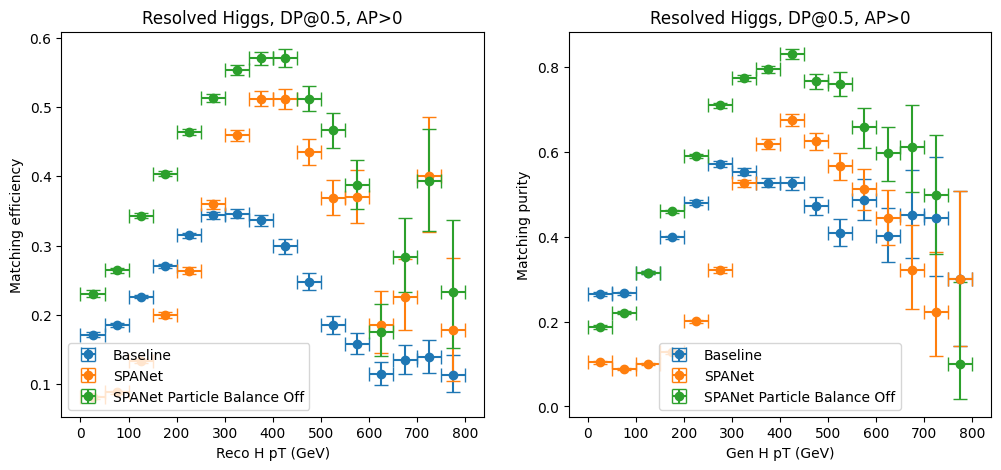

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=eff_b, xerr=xerr, yerr=efferr_b, fmt='o', capsize=5, label='Baseline')
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='SPANet')
ax[0].errorbar(x=bin_centers, y=eff_pb, xerr=xerr, yerr=efferr_pb, fmt='o', capsize=5, label='SPANet Particle Balance Off')

ax[1].errorbar(x=bin_centers, y=pur_b, xerr=xerr, yerr=purerr_b, fmt='o', capsize=5, label='Baseline')
ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='SPANet')
ax[1].errorbar(x=bin_centers, y=pur_pb, xerr=xerr, yerr=purerr_pb, fmt='o', capsize=5, label='SPANet Particle Balance Off')


ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Resolved Higgs, DP@{dp_cut}, AP>0")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Resolved Higgs, DP@{dp_cut}, AP>0")
ax[0].legend()
ax[1].legend()

### Investigating the low pT region

In [15]:
targetHs = [targetH for event in LUT_pred_spanet for targetH in event]
targetHs = np.array(targetHs)

targetHs_inds = np.digitize(targetHs[:,1], bins)

correctTruth_per_bin = []
for bin_i in range(1, len(bins)):
    correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
correctTruth_per_bin = ak.Array(correctTruth_per_bin)

In [16]:
correctTruth_per_bin[0]

<Array [1, 1, 0, 0, 0, 1, 0, 0, ..., 1, 0, 0, 1, 0, 0, 0] type='6943 * float64'>

In [17]:
targetHs = [targetH for event in LUT_target_spanet for targetH in event]
targetHs = np.array(targetHs)

targetHs_inds = np.digitize(targetHs[:,1], bins)

correctTruth_per_bin = []
for bin_i in range(1, len(bins)):
    correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
correctTruth_per_bin = ak.Array(correctTruth_per_bin)

In [18]:
print(type(correctTruth_per_bin[0]))

<class 'awkward.highlevel.Array'>


In [19]:
targetHs = [targetH for event in LUT_target_base for targetH in event]
targetHs = np.array(targetHs)

targetHs_inds = np.digitize(targetHs[:,1], bins)

correctTruth_per_bin = []
for bin_i in range(1, len(bins)):
    correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
correctTruth_per_bin = ak.Array(correctTruth_per_bin)
correctTruth_per_bin[0]

<Array [0, 1, 0, 0, 0, 0, 0, 0, ..., 1, 0, 1, 0, 0, 1, 0] type='7756 * float64'>

#### Try examing LUT event by event

In [20]:
for event_pred, event_target in zip(LUT_pred_spanet, LUT_target_spanet):
    print("Reco:", event_pred, "Target:", event_target)

Reco: [[0, 91.1, 0, 3]] Target: [[0, 112, 2, 5], [0, 111, 1, 3]]
Reco: [[1, 137, 2, 4], [1, 263, 1, 3]] Target: [[1, 147, 2, 4], [1, 276, 1, 3]]
Reco: [[0, 75.7, 4, 5]] Target: [[0, 198, 1, 2]]
Reco: [[0, 262, 2, 4]] Target: [[0, 162, 0, 1]]
Reco: [[0, 151, 3, 6], [1, 249, 1, 2], [1, 251, 0, 4]] Target: [[1, 282, 1, 2], [0, 42.4, 5, 6], [1, 242, 0, 4]]
Reco: [[1, 175, 0, 2]] Target: [[0, 91.7, 3, 6], [0, 231, 1, 4], [1, 171, 0, 2]]
Reco: [[1, 219, 2, 5], [0, 202, 0, 3]] Target: [[0, 218, 1, 3], [0, 63.1, 0, 4], [1, 207, 2, 5]]
Reco: [] Target: [[0, 186, 1, 3]]
Reco: [[1, 170, 2, 3], [1, 457, 0, 6], [1, 365, 1, 4]] Target: [[1, 470, 0, 6], [1, 382, 1, 4], [1, 154, 2, 3]]
Reco: [[0, 122, 3, 5], [1, 249, 1, 2], [0, 237, 0, 4]] Target: [[1, 301, 1, 2], [0, 150, 4, 5], [0, 207, 0, 3]]
Reco: [[1, 259, 2, 4], [0, 308, 0, 3], [0, 266, 1, 6]] Target: [[0, 58.2, 1, 3], [0, 141, 6, 8], [1, 279, 2, 4]]
Reco: [[0, 62, 2, 5], [1, 201, 0, 4], [0, 162, 1, 3]] Target: [[1, 212, 0, 4], [0, 153, 1, 2]]
R

Reco: [[0, 63.2, 4, 6], [1, 151, 0, 3], [0, 147, 1, 2]] Target: [[1, 141, 0, 3]]
Reco: [[0, 91.6, 4, 5], [0, 126, 0, 2]] Target: [[0, 170, 0, 1], [0, 50.6, 2, 3]]
Reco: [[1, 213, 0, 3]] Target: [[0, 177, 2, 5], [1, 270, 0, 3]]
Reco: [[0, 96.2, 2, 3]] Target: [[0, 75, 0, 2], [0, 20.3, 1, 3]]
Reco: [[1, 124, 3, 6], [1, 314, 0, 2], [1, 367, 1, 5]] Target: [[1, 141, 3, 6], [1, 345, 1, 5], [1, 313, 0, 2]]
Reco: [[0, 193, 4, 7], [1, 231, 0, 2], [1, 156, 1, 3]] Target: [[1, 273, 0, 2], [1, 162, 1, 3]]
Reco: [[0, 442, 0, 1], [1, 236, 2, 4]] Target: [[1, 260, 2, 4]]
Reco: [[0, 115, 5, 6], [0, 79, 0, 3]] Target: [[0, 82.7, 0, 1], [0, 17.8, 2, 3]]
Reco: [[0, 154, 1, 5], [1, 320, 0, 2]] Target: [[1, 359, 0, 2], [0, 93.2, 3, 4]]
Reco: [[1, 112, 1, 3], [1, 176, 0, 4]] Target: [[1, 172, 0, 4], [1, 115, 1, 3]]
Reco: [[0, 189, 0, 4]] Target: [[0, 21.6, 3, 5], [0, 102, 1, 4], [0, 94.2, 0, 2]]
Reco: [[0, 35.4, 4, 6], [0, 218, 0, 3], [1, 277, 1, 2]] Target: [[0, 192, 3, 4], [1, 320, 1, 2]]
Reco: [[0, 73.4

Reco: [[0, 109, 2, 6], [0, 226, 1, 5], [0, 298, 0, 4]] Target: [[0, 160, 3, 4], [0, 282, 0, 5]]
Reco: [[0, 71.6, 1, 3], [1, 90.7, 0, 2]] Target: [[1, 78, 0, 2], [0, 68.2, 3, 4]]
Reco: [[0, 351, 1, 4], [1, 491, 0, 2]] Target: [[1, 584, 0, 2]]
Reco: [[1, 49.7, 1, 4]] Target: [[0, 104, 3, 5], [1, 51.7, 1, 4], [0, 133, 0, 2]]
Reco: [[0, 146, 4, 5], [1, 409, 1, 3]] Target: [[0, 541, 0, 2], [1, 404, 1, 3]]
Reco: [[0, 180, 1, 4], [0, 101, 0, 3], [1, 200, 2, 5]] Target: [[0, 209, 0, 4], [1, 231, 2, 5]]
Reco: [[1, 160, 3, 5], [1, 295, 1, 4]] Target: [[1, 180, 3, 5], [1, 286, 1, 4]]
Reco: [[1, 117, 3, 4], [1, 354, 1, 2], [1, 340, 0, 5]] Target: [[1, 320, 1, 2], [1, 138, 3, 4], [1, 331, 0, 5]]
Reco: [[1, 60.6, 2, 3], [1, 183, 0, 4], [0, 222, 1, 5]] Target: [[1, 48.7, 2, 3], [1, 203, 0, 4]]
Reco: [[1, 144, 1, 3], [0, 169, 0, 6]] Target: [[0, 161, 0, 2], [1, 161, 1, 3]]
Reco: [[0, 155, 3, 5], [1, 240, 0, 4], [1, 143, 1, 2]] Target: [[1, 225, 0, 4], [1, 138, 1, 2]]
Reco: [[0, 195, 2, 3], [1, 255, 0,

Reco: [[1, 278, 2, 3], [0, 341, 0, 1]] Target: [[1, 342, 2, 3], [0, 287, 1, 5], [0, 63.6, 0, 4]]
Reco: [] Target: [[0, 94.3, 2, 4]]
Reco: [[1, 228, 1, 2], [0, 271, 0, 7], [1, 348, 3, 4]] Target: [[1, 395, 3, 4], [1, 231, 1, 2]]
Reco: [[0, 10.7, 2, 5], [0, 63.2, 1, 3]] Target: [[0, 51.3, 3, 5], [0, 60.5, 0, 4]]
Reco: [[1, 277, 1, 2]] Target: [[1, 318, 1, 2]]
Reco: [[0, 122, 0, 8]] Target: [[0, 158, 0, 1]]
Reco: [[1, 385, 0, 4], [0, 6.29, 1, 5]] Target: [[1, 432, 0, 4]]
Reco: [[1, 301, 3, 5], [1, 314, 1, 2]] Target: [[1, 378, 1, 2], [1, 294, 3, 5]]
Reco: [] Target: [[0, 155, 1, 3]]
Reco: [[1, 88.5, 1, 7], [0, 193, 3, 5], [1, 298, 0, 2]] Target: [[0, 297, 3, 4], [1, 91, 1, 7], [1, 407, 0, 2]]
Reco: [[0, 625, 1, 3], [0, 162, 0, 4]] Target: [[0, 410, 0, 3]]
Reco: [[0, 35.1, 3, 4], [0, 189, 1, 2]] Target: [[0, 90.9, 2, 3], [0, 216, 0, 5]]
Reco: [[0, 122, 1, 2]] Target: [[0, 182, 0, 5], [0, 74.9, 1, 6], [0, 74.2, 2, 3]]
Reco: [[1, 250, 0, 3], [0, 74, 4, 5], [0, 230, 1, 2]] Target: [[0, 173, 1

Reco: [[0, 105, 0, 2]] Target: [[0, 159, 0, 1], [0, 59.1, 2, 5]]
Reco: [[0, 107, 1, 4], [0, 244, 0, 2]] Target: [[0, 133, 1, 3], [0, 125, 2, 4]]
Reco: [[0, 85.4, 1, 5], [0, 170, 0, 3]] Target: [[0, 212, 3, 5], [0, 184, 0, 1]]
Reco: [[0, 141, 1, 3]] Target: [[0, 183, 0, 4], [0, 46.7, 1, 2]]
Reco: [[0, 83.9, 2, 3], [0, 180, 0, 1]] Target: [[0, 98.6, 2, 7], [0, 136, 0, 3], [0, 179, 1, 4]]
Reco: [] Target: [[0, 91.3, 0, 3], [0, 128, 2, 5]]
Reco: [[0, 80.2, 2, 3], [0, 81.2, 1, 8], [0, 201, 0, 4]] Target: [[0, 145, 2, 6]]
Reco: [[0, 133, 0, 4], [0, 106, 1, 6], [0, 170, 2, 3]] Target: [[0, 71.6, 3, 5], [0, 181, 0, 1], [0, 79.1, 2, 4]]
Reco: [[0, 86.9, 3, 5], [0, 225, 1, 4], [1, 452, 0, 2]] Target: [[1, 452, 0, 2], [0, 72.8, 3, 4], [0, 201, 1, 5]]
Reco: [[0, 189, 2, 4], [1, 203, 0, 5]] Target: [[0, 188, 2, 3], [1, 205, 0, 5]]
Reco: [[0, 118, 1, 4], [1, 269, 0, 2]] Target: [[0, 56.3, 3, 4], [1, 249, 0, 2]]
Reco: [[1, 181, 0, 5], [0, 238, 1, 3]] Target: [[1, 212, 0, 5], [0, 56.7, 2, 4], [0, 178,

Reco: [[0, 65.8, 0, 2], [1, 61, 1, 3]] Target: [[1, 60.9, 1, 3], [0, 57.4, 0, 5], [0, 69.6, 2, 4]]
Reco: [[0, 65.8, 2, 3], [0, 24.5, 6, 8], [1, 110, 1, 4]] Target: [[0, 45, 0, 2], [1, 131, 1, 4]]
Reco: [[0, 368, 3, 4], [0, 74, 5, 7], [0, 44.3, 0, 1]] Target: [[0, 69, 1, 5]]
Reco: [[0, 23.6, 2, 3], [0, 167, 0, 4], [0, 180, 1, 6]] Target: [[0, 158, 0, 3], [0, 76, 2, 4]]
Reco: [[0, 134, 1, 4]] Target: [[0, 209, 0, 2]]
Reco: [[0, 157, 1, 4], [1, 111, 0, 2]] Target: [[1, 36.1, 0, 2]]
Reco: [[0, 269, 1, 2], [0, 138, 5, 7], [0, 131, 0, 6]] Target: [[0, 281, 3, 6]]
Reco: [[0, 78.2, 1, 3], [0, 121, 0, 6]] Target: [[0, 53.5, 0, 2], [0, 116, 1, 4], [0, 86.7, 3, 5]]
Reco: [[0, 54.7, 1, 2]] Target: [[0, 140, 2, 3], [0, 47.4, 0, 5], [0, 90.8, 1, 4]]
Reco: [[0, 22.6, 7, 8], [0, 63.9, 1, 2], [0, 73.3, 0, 3]] Target: [[0, 70.7, 0, 8], [0, 18.4, 3, 4]]
Reco: [[1, 216, 0, 2], [0, 32.2, 3, 4], [0, 172, 1, 5]] Target: [[1, 142, 0, 2], [0, 213, 1, 4]]
Reco: [[0, 181, 3, 6], [0, 55, 0, 1], [0, 183, 2, 4]] Ta

Reco: [[0, 69.1, 1, 3], [1, 268, 0, 2], [0, 181, 4, 5]] Target: [[0, 178, 3, 5], [1, 277, 0, 2]]
Reco: [[1, 52.7, 2, 3], [1, 186, 0, 1]] Target: [[1, 178, 0, 1], [1, 66.3, 2, 3]]
Reco: [[0, 65.1, 1, 3], [1, 228, 0, 7], [0, 68.2, 2, 4]] Target: [[1, 165, 0, 7], [0, 29.7, 2, 3]]
Reco: [[1, 247, 0, 2]] Target: [[1, 243, 0, 2]]
Reco: [[0, 137, 4, 7], [1, 109, 0, 3], [0, 57, 1, 5]] Target: [[1, 88.1, 0, 3], [0, 146, 2, 4]]
Reco: [[0, 199, 1, 3]] Target: [[0, 296, 0, 2]]
Reco: [[0, 144, 1, 2], [0, 145, 0, 4]] Target: [[0, 144, 0, 7], [0, 149, 2, 3]]
Reco: [[0, 225, 3, 4], [0, 282, 0, 1]] Target: [[0, 111, 1, 4]]
Reco: [[1, 67.5, 5, 6], [1, 146, 0, 1], [0, 75.6, 2, 3]] Target: [[1, 151, 0, 1], [1, 140, 5, 6], [0, 76.5, 2, 8]]
Reco: [[0, 315, 0, 1]] Target: [[0, 172, 0, 4]]
Reco: [] Target: [[0, 210, 1, 2], [0, 122, 0, 3]]
Reco: [[1, 156, 2, 5], [1, 202, 1, 3]] Target: [[1, 188, 1, 3], [1, 145, 2, 5]]
Reco: [[1, 230, 0, 3], [1, 254, 1, 6]] Target: [[1, 248, 1, 6], [1, 189, 0, 3]]
Reco: [[1, 61

Reco: [[1, 35.1, 1, 2], [1, 65.5, 3, 7]] Target: [[1, 52.7, 1, 2], [0, 63.9, 0, 4], [1, 42.2, 3, 7]]
Reco: [[1, 138, 0, 1]] Target: [[1, 115, 0, 1], [0, 8.93, 2, 3]]
Reco: [[0, 27.2, 2, 3], [0, 159, 0, 6], [0, 293, 1, 4]] Target: [[0, 152, 0, 2], [0, 166, 3, 4]]
Reco: [[0, 125, 1, 4]] Target: [[0, 252, 2, 4], [0, 336, 0, 1]]
Reco: [[1, 102, 2, 3], [0, 29.2, 4, 6], [0, 336, 0, 1]] Target: [[0, 185, 1, 4], [0, 202, 0, 6], [1, 93.3, 2, 3]]
Reco: [[1, 232, 0, 6]] Target: [[1, 228, 0, 6], [0, 251, 3, 7]]
Reco: [[1, 145, 1, 2], [1, 266, 0, 4]] Target: [[1, 211, 0, 4], [1, 118, 1, 2], [0, 27.1, 3, 5]]
Reco: [[0, 100, 2, 7], [1, 302, 1, 5], [0, 351, 0, 3]] Target: [[1, 317, 1, 5]]
Reco: [[1, 148, 0, 2]] Target: [[1, 151, 0, 2], [0, 181, 1, 5]]
Reco: [[0, 61.9, 2, 8], [0, 154, 0, 1]] Target: [[0, 147, 0, 2]]
Reco: [[0, 142, 0, 1], [0, 165, 2, 4]] Target: [[0, 14.9, 0, 4]]
Reco: [[0, 91.8, 4, 6], [1, 32.2, 1, 3], [1, 144, 0, 2]] Target: [[1, 157, 0, 2], [1, 35.9, 1, 3]]
Reco: [[0, 134, 3, 4], [0

Reco: [[0, 92.7, 5, 6], [1, 538, 0, 1], [0, 107, 2, 4]] Target: [[1, 428, 0, 1], [0, 53.4, 2, 5]]
Reco: [[1, 126, 1, 2], [0, 128, 3, 5], [0, 226, 0, 4]] Target: [[0, 105, 3, 4], [1, 138, 1, 2]]
Reco: [[1, 122, 1, 5], [1, 108, 2, 4]] Target: [[0, 194, 0, 3], [1, 147, 1, 5], [1, 139, 2, 4]]
Reco: [[0, 129, 3, 5], [0, 170, 0, 1]] Target: [[0, 386, 2, 7], [0, 179, 1, 5]]
Reco: [[0, 27.1, 3, 5], [0, 237, 1, 4], [0, 188, 0, 2]] Target: [[0, 107, 1, 2]]
Reco: [[0, 62.8, 2, 5], [0, 209, 0, 4], [0, 180, 1, 3]] Target: [[0, 280, 0, 2], [0, 59.6, 3, 4], [0, 164, 1, 5]]
Reco: [[1, 272, 0, 2]] Target: [[0, 30.4, 4, 5], [0, 232, 1, 3], [1, 266, 0, 2]]
Reco: [[0, 207, 6, 7], [0, 69, 1, 2], [0, 410, 0, 4]] Target: [[0, 383, 1, 4], [0, 111, 0, 2]]
Reco: [[0, 142, 0, 5], [0, 223, 3, 4]] Target: [[0, 273, 0, 4], [0, 215, 2, 6]]
Reco: [[0, 108, 2, 4]] Target: [[0, 43.7, 1, 4], [0, 107, 0, 2]]
Reco: [[0, 76.1, 1, 4], [0, 224, 2, 3]] Target: [[0, 210, 0, 5], [0, 219, 3, 4], [0, 92.4, 1, 2]]
Reco: [[1, 119, 

Reco: [[1, 396, 0, 3], [1, 210, 1, 5]] Target: [[1, 206, 1, 5], [1, 362, 0, 3]]
Reco: [[1, 208, 2, 5], [1, 214, 1, 4], [1, 271, 0, 3]] Target: [[1, 225, 1, 4], [1, 220, 2, 5], [1, 229, 0, 3]]
Reco: [[0, 25.9, 1, 2]] Target: [[0, 27.1, 1, 4], [0, 96.1, 0, 2]]
Reco: [[1, 186, 2, 5], [0, 387, 0, 1], [0, 91.3, 3, 6]] Target: [[1, 193, 2, 5], [0, 59, 0, 3]]
Reco: [[0, 332, 0, 4]] Target: [[0, 172, 0, 5]]
Reco: [[0, 220, 0, 2], [1, 175, 1, 5]] Target: [[0, 291, 0, 4], [1, 221, 1, 5]]
Reco: [[0, 91.2, 2, 3], [1, 288, 0, 6], [0, 161, 1, 4]] Target: [[0, 102, 2, 4], [1, 296, 0, 6], [0, 158, 1, 3]]
Reco: [[0, 54.3, 5, 7], [0, 55, 2, 3], [0, 124, 0, 4]] Target: [[0, 72.8, 0, 2], [0, 17.3, 1, 4]]
Reco: [[0, 57.8, 2, 3]] Target: [[0, 96.5, 0, 2]]
Reco: [[0, 172, 1, 2]] Target: [[0, 142, 0, 4]]
Reco: [[0, 196, 3, 4]] Target: [[0, 210, 0, 2], [0, 95.1, 1, 6]]
Reco: [[1, 315, 0, 2]] Target: [[1, 304, 0, 2]]
Reco: [[0, 178, 2, 5], [1, 229, 1, 3]] Target: [[1, 240, 1, 3]]
Reco: [[0, 307, 1, 4], [0, 147,

Reco: [[0, 111, 4, 5], [0, 43.1, 1, 2], [0, 324, 0, 6]] Target: [[0, 122, 1, 6]]
Reco: [[1, 81.8, 2, 6], [1, 162, 0, 1], [0, 116, 5, 8]] Target: [[1, 131, 2, 6], [1, 164, 0, 1], [0, 10.6, 4, 8]]
Reco: [[0, 93.3, 3, 6], [1, 201, 0, 1]] Target: [[0, 146, 3, 5], [0, 115, 2, 6], [1, 199, 0, 1]]
Reco: [[1, 185, 3, 5], [1, 193, 1, 2], [1, 210, 0, 4]] Target: [[1, 144, 1, 2], [1, 187, 3, 5], [1, 234, 0, 4]]
Reco: [[1, 74.5, 3, 6], [0, 139, 1, 2]] Target: [[0, 113, 4, 5], [0, 206, 0, 2], [1, 93.8, 3, 6]]
Reco: [[0, 227, 1, 6], [1, 134, 0, 4], [1, 13.1, 2, 3]] Target: [[1, 163, 0, 4], [1, 23.6, 2, 3]]
Reco: [[1, 133, 0, 3]] Target: [[0, 76.7, 1, 4], [1, 114, 0, 3]]
Reco: [[0, 85.8, 3, 5], [1, 176, 0, 4]] Target: [[1, 158, 0, 4]]
Reco: [[0, 247, 4, 6], [0, 213, 0, 3]] Target: [[0, 183, 1, 6], [0, 138, 0, 2]]
Reco: [[0, 84.7, 4, 6], [0, 116, 0, 3]] Target: [[0, 71.3, 0, 6], [0, 166, 1, 2]]
Reco: [[0, 251, 0, 3], [1, 180, 1, 6], [0, 63.9, 2, 4]] Target: [[0, 199, 2, 3], [0, 41.1, 0, 4], [1, 233, 1

Reco: [[0, 125, 1, 3], [0, 242, 0, 2], [0, 410, 4, 5]] Target: [[0, 107, 3, 5], [0, 210, 0, 1]]
Reco: [[0, 226, 0, 5], [0, 207, 3, 4], [0, 188, 1, 2]] Target: [[0, 174, 1, 4], [0, 176, 0, 2]]
Reco: [[0, 129, 0, 1]] Target: [[0, 76.9, 2, 3]]
Reco: [[0, 65.8, 4, 5], [0, 146, 1, 3]] Target: [[0, 184, 0, 2], [0, 192, 1, 6], [0, 63.3, 3, 4]]
Reco: [] Target: []
Reco: [[0, 235, 0, 3]] Target: [[0, 179, 0, 6], [0, 67.8, 1, 3]]
Reco: [[0, 14.7, 3, 5], [0, 285, 1, 4], [1, 366, 0, 2]] Target: [[0, 432, 1, 5], [0, 181, 3, 4], [1, 258, 0, 2]]
Reco: [[0, 53.7, 4, 9], [1, 403, 1, 2]] Target: [[1, 438, 1, 2], [0, 579, 0, 3]]
Reco: [] Target: []
Reco: [[0, 158, 2, 4], [0, 114, 1, 3], [0, 259, 0, 5]] Target: [[0, 203, 1, 2]]
Reco: [[0, 150, 1, 5], [1, 259, 0, 2]] Target: [[1, 238, 0, 2], [0, 359, 3, 7]]
Reco: [[1, 82, 0, 4]] Target: [[1, 103, 0, 4], [0, 274, 1, 3]]
Reco: [[0, 78.8, 3, 7], [1, 172, 1, 6], [1, 170, 0, 2]] Target: [[1, 199, 1, 6], [1, 174, 0, 2]]
Reco: [[1, 195, 0, 3]] Target: [[1, 160, 0

Reco: [[0, 83.7, 2, 4]] Target: [[0, 185, 0, 2], [0, 192, 1, 9]]
Reco: [[0, 9.68, 4, 5], [0, 153, 0, 3]] Target: [[0, 131, 1, 6], [0, 16.4, 3, 4], [0, 97.1, 0, 2]]
Reco: [[1, 211, 1, 4], [1, 275, 0, 3]] Target: [[0, 61.7, 2, 6], [1, 289, 0, 3], [1, 217, 1, 4]]
Reco: [[0, 153, 3, 4], [0, 212, 0, 2]] Target: [[0, 111, 1, 3]]
Reco: [[0, 84, 0, 4]] Target: [[0, 76.4, 2, 3]]
Reco: [[1, 79.1, 2, 4], [0, 187, 0, 1]] Target: [[0, 98.4, 0, 6], [1, 76.2, 2, 4], [0, 75, 1, 3]]
Reco: [[0, 256, 6, 7], [1, 210, 0, 3]] Target: [[0, 210, 2, 4], [1, 211, 0, 3]]
Reco: [[0, 118, 1, 2]] Target: [[0, 73.9, 1, 4]]
Reco: [[0, 110, 3, 6]] Target: [[0, 71.1, 0, 4]]
Reco: [[0, 76.6, 1, 5], [1, 112, 2, 4]] Target: [[0, 173, 1, 6], [1, 154, 2, 4]]
Reco: [[0, 66.9, 5, 7], [1, 245, 0, 2], [1, 152, 1, 3]] Target: [[1, 263, 0, 2], [1, 165, 1, 3]]
Reco: [[0, 55.9, 4, 6], [0, 67.2, 3, 5], [0, 175, 0, 1]] Target: [[0, 112, 1, 4], [0, 88.4, 0, 2]]
Reco: [[0, 93.9, 2, 4], [1, 221, 3, 6], [1, 227, 0, 1]] Target: [[1, 229, 

Reco: [[0, 123, 2, 3], [0, 60.2, 4, 6], [0, 199, 0, 1]] Target: [[0, 42.7, 3, 7], [0, 117, 1, 4], [0, 210, 0, 2]]
Reco: [[0, 57.6, 2, 4], [0, 45.8, 1, 3], [0, 89.7, 0, 5]] Target: [[0, 101, 4, 5], [0, 99.3, 1, 2], [0, 29.5, 0, 3]]
Reco: [[1, 96.9, 2, 3], [1, 275, 1, 4], [1, 464, 0, 5]] Target: [[1, 330, 1, 4], [1, 455, 0, 5], [1, 125, 2, 3]]
Reco: [[1, 98.9, 3, 5], [1, 387, 0, 2], [1, 273, 1, 4]] Target: [[1, 441, 0, 2], [1, 101, 3, 5], [1, 329, 1, 4]]
Reco: [[0, 62.8, 2, 5]] Target: [[0, 261, 1, 5], [0, 260, 0, 4]]
Reco: [[1, 113, 0, 1]] Target: [[1, 121, 0, 1]]
Reco: [[1, 90.6, 2, 4], [0, 247, 1, 3], [0, 278, 0, 5]] Target: [[1, 107, 2, 4]]
Reco: [[1, 80.4, 3, 5], [1, 298, 1, 4], [1, 317, 0, 2]] Target: [[1, 378, 1, 4], [1, 259, 0, 2], [1, 129, 3, 5]]
Reco: [[0, 141, 1, 3], [0, 103, 0, 2]] Target: [[0, 136, 0, 4], [0, 157, 1, 2]]
Reco: [[1, 192, 1, 4], [1, 163, 0, 3]] Target: [[0, 88.2, 2, 5], [1, 182, 1, 4], [1, 211, 0, 3]]
Reco: [[0, 197, 3, 5], [0, 349, 0, 1], [1, 193, 2, 4]] Targ

Reco: [[1, 275, 0, 2], [1, 205, 1, 6]] Target: [[1, 205, 1, 6], [1, 244, 0, 2]]
Reco: [[0, 118, 1, 4], [0, 205, 2, 3]] Target: [[0, 173, 1, 3], [0, 74.7, 2, 4]]
Reco: [[0, 583, 3, 4]] Target: [[0, 394, 0, 1]]
Reco: [[1, 145, 2, 3], [0, 77.9, 6, 7], [1, 329, 0, 1]] Target: [[1, 317, 0, 1], [1, 139, 2, 3], [0, 181, 5, 6]]
Reco: [[0, 281, 3, 4], [1, 152, 0, 6], [1, 93.2, 1, 9]] Target: [[1, 138, 0, 6], [1, 121, 1, 9], [0, 58.7, 3, 5]]
Reco: [[1, 231, 3, 4], [1, 159, 0, 1]] Target: [[1, 225, 3, 4], [1, 198, 0, 1]]
Reco: [[0, 132, 0, 5]] Target: []
Reco: [[0, 271, 2, 3], [0, 191, 0, 5], [1, 196, 1, 4]] Target: [[1, 212, 1, 4], [0, 76.9, 2, 5]]
Reco: [[0, 206, 3, 6], [0, 114, 0, 4]] Target: []
Reco: [] Target: [[0, 58, 0, 1]]
Reco: [[0, 45.7, 1, 2], [0, 97.7, 0, 5]] Target: [[0, 44.9, 1, 5], [0, 50.1, 2, 4]]
Reco: [[1, 96, 0, 2], [0, 193, 1, 5]] Target: [[1, 125, 0, 2], [0, 285, 4, 5]]
Reco: [[0, 144, 1, 6], [1, 192, 0, 2]] Target: [[0, 95.4, 1, 4], [1, 200, 0, 2]]
Reco: [[1, 32.3, 1, 2]] Ta

Reco: [[0, 643, 3, 6]] Target: [[0, 271, 1, 2], [0, 350, 0, 4]]
Reco: [] Target: [[0, 56.3, 4, 6], [0, 87.6, 1, 2]]
Reco: [[0, 76.7, 4, 6], [0, 207, 1, 2], [1, 239, 0, 3]] Target: [[1, 264, 0, 3], [0, 259, 1, 6], [0, 80.4, 2, 4]]
Reco: [[0, 53.2, 4, 6], [1, 239, 1, 3], [1, 273, 0, 2]] Target: [[1, 264, 1, 3], [1, 258, 0, 2]]
Reco: [[0, 179, 1, 2], [0, 89.9, 0, 5]] Target: [[0, 111, 1, 3]]
Reco: [[0, 85.7, 4, 9], [0, 243, 1, 3], [0, 225, 0, 7]] Target: [[0, 87.5, 1, 7]]
Reco: [[1, 144, 0, 1]] Target: [[1, 161, 0, 1]]
Reco: [[0, 417, 4, 6], [1, 138, 1, 3]] Target: [[0, 332, 0, 6], [1, 138, 1, 3]]
Reco: [[0, 64.3, 5, 6], [0, 144, 0, 2]] Target: [[0, 81.2, 4, 7], [0, 20.9, 1, 6]]
Reco: [[0, 129, 4, 7], [0, 64.7, 0, 1], [0, 226, 3, 6]] Target: [[0, 148, 0, 2], [0, 145, 3, 4]]
Reco: [[0, 57.6, 2, 7], [0, 182, 0, 4], [0, 109, 3, 8]] Target: [[0, 76.9, 2, 9]]
Reco: [[0, 356, 1, 2]] Target: [[0, 353, 0, 1]]
Reco: [[1, 257, 0, 5]] Target: [[1, 320, 0, 5], [0, 195, 1, 2]]
Reco: [[0, 330, 0, 1]] T

Reco: [[0, 501, 2, 3], [0, 325, 4, 5], [0, 255, 0, 1]] Target: [[0, 65.8, 1, 6]]
Reco: [[1, 210, 1, 2], [1, 240, 0, 5]] Target: [[1, 180, 1, 2], [1, 249, 0, 5]]
Reco: [[0, 219, 3, 4], [1, 210, 0, 2]] Target: [[0, 37.5, 3, 5], [1, 256, 0, 2]]
Reco: [[0, 19.9, 3, 5], [0, 212, 1, 2], [0, 319, 0, 4]] Target: [[0, 72.1, 2, 4], [0, 217, 0, 3]]
Reco: [[0, 159, 1, 3], [1, 166, 0, 2]] Target: [[1, 184, 0, 2], [0, 90.4, 1, 6]]
Reco: [[0, 99.8, 4, 5], [1, 364, 2, 3], [1, 297, 0, 1]] Target: [[1, 293, 0, 1], [1, 360, 2, 3]]
Reco: [[1, 300, 1, 3]] Target: [[1, 201, 1, 3]]
Reco: [[1, 104, 0, 1]] Target: [[1, 96.6, 0, 1]]
Reco: [[0, 61.8, 2, 3], [0, 264, 0, 1]] Target: [[0, 606, 0, 2]]
Reco: [[0, 70.8, 2, 6], [1, 196, 1, 3]] Target: [[0, 88.1, 0, 5], [1, 171, 1, 3]]
Reco: [[0, 156, 2, 7], [0, 202, 1, 4], [1, 389, 0, 3]] Target: [[0, 85.2, 4, 7], [1, 373, 0, 3], [0, 185, 2, 8]]
Reco: [[0, 130, 2, 5], [0, 177, 1, 3]] Target: [[0, 38, 0, 1], [0, 160, 2, 4]]
Reco: [[0, 91.2, 2, 5], [1, 195, 0, 1]] Target

Reco: [[0, 195, 0, 4], [0, 123, 1, 2]] Target: [[0, 107, 2, 6], [0, 97.9, 0, 1]]
Reco: [[0, 247, 1, 3], [0, 209, 2, 6], [1, 477, 0, 4]] Target: [[1, 552, 0, 4], [0, 365, 1, 2]]
Reco: [[0, 39.6, 7, 9], [0, 185, 0, 3], [0, 102, 1, 4]] Target: [[0, 44, 0, 1]]
Reco: [[0, 457, 2, 3], [0, 197, 0, 4]] Target: [[0, 98.5, 2, 4]]
Reco: [] Target: [[0, 182, 0, 4]]
Reco: [[0, 245, 2, 3], [0, 205, 0, 5], [0, 78.4, 1, 4]] Target: [[0, 128, 1, 5], [0, 168, 0, 4]]
Reco: [[0, 30.5, 3, 5], [0, 195, 0, 1], [0, 294, 2, 4]] Target: [[0, 242, 1, 4], [0, 30.5, 2, 3]]
Reco: [[0, 181, 1, 4], [0, 246, 0, 3], [0, 129, 2, 8]] Target: [[0, 204, 1, 5], [0, 104, 2, 3]]
Reco: [[1, 181, 2, 4], [0, 110, 1, 3]] Target: [[0, 285, 0, 7], [1, 120, 2, 4]]
Reco: [[0, 244, 1, 3]] Target: [[0, 260, 1, 5]]
Reco: [[0, 14.4, 5, 6], [0, 293, 0, 2]] Target: [[0, 188, 0, 4]]
Reco: [[0, 72.6, 2, 6], [1, 92.2, 1, 4], [0, 252, 0, 3]] Target: [[0, 111, 2, 3], [1, 90.5, 1, 4], [0, 288, 0, 6]]
Reco: [[1, 93.4, 0, 4], [1, 79.2, 1, 3]] Targ

Reco: [[0, 35.2, 1, 5], [1, 155, 0, 4]] Target: [[0, 70.4, 2, 5], [1, 145, 0, 4]]
Reco: [[0, 205, 3, 5], [1, 144, 0, 2]] Target: [[0, 86.2, 1, 7], [1, 210, 0, 2]]
Reco: [[0, 180, 3, 6], [0, 83.5, 1, 2], [0, 249, 0, 5]] Target: [[0, 156, 3, 7], [0, 4.88, 2, 5], [0, 102, 0, 1]]
Reco: [[0, 47.4, 0, 4], [0, 82.2, 1, 2]] Target: [[0, 135, 2, 5], [0, 75.1, 1, 3]]
Reco: [[0, 71.2, 3, 5], [1, 258, 1, 4], [0, 171, 0, 2]] Target: [[1, 272, 1, 4], [0, 63.7, 0, 6]]
Reco: [[1, 126, 1, 2], [1, 222, 0, 4]] Target: [[1, 235, 0, 4], [1, 148, 1, 2]]
Reco: [[0, 215, 2, 3], [1, 156, 0, 1]] Target: [[1, 113, 0, 1]]
Reco: [[1, 497, 0, 2]] Target: [[1, 430, 0, 2]]
Reco: [[0, 295, 3, 6], [1, 139, 1, 2], [0, 463, 0, 5]] Target: [[1, 135, 1, 2]]
Reco: [[0, 206, 1, 6], [1, 233, 2, 5], [1, 352, 0, 3]] Target: [[1, 343, 0, 3], [1, 206, 2, 5]]
Reco: [[0, 101, 3, 6], [0, 91.3, 1, 4]] Target: [[0, 189, 1, 5]]
Reco: [[1, 82.1, 2, 4], [1, 171, 0, 3], [1, 140, 1, 5]] Target: [[1, 83.2, 2, 4], [1, 155, 1, 5], [1, 164, 0,

Reco: [[0, 159, 0, 4]] Target: [[0, 206, 1, 4], [0, 198, 2, 3]]
Reco: [[0, 201, 2, 5], [0, 167, 1, 7], [0, 392, 0, 3]] Target: [[0, 196, 0, 1]]
Reco: [[0, 201, 0, 2], [0, 163, 3, 4]] Target: [[0, 199, 1, 3], [0, 242, 0, 5]]
Reco: [[1, 118, 0, 2]] Target: [[0, 79.3, 1, 5], [1, 116, 0, 2]]
Reco: [[0, 81.6, 5, 6], [1, 280, 0, 2], [0, 320, 1, 3]] Target: [[1, 310, 0, 2], [0, 221, 1, 5]]
Reco: [[1, 49.9, 3, 6], [1, 126, 2, 4], [1, 172, 0, 1]] Target: [[1, 51.3, 3, 6], [1, 180, 0, 1], [1, 102, 2, 4]]
Reco: [[1, 13.6, 2, 3], [0, 25.9, 4, 5]] Target: [[0, 197, 0, 5], [1, 16.8, 2, 3]]
Reco: [[1, 21, 1, 3]] Target: [[1, 39.1, 1, 3], [0, 124, 0, 6]]
Reco: [[1, 61.8, 2, 4], [1, 129, 1, 5], [0, 172, 0, 3]] Target: [[1, 131, 1, 5], [1, 64.9, 2, 4], [0, 135, 0, 8]]
Reco: [] Target: [[0, 158, 3, 5]]
Reco: [[0, 31.9, 4, 6], [0, 60.9, 2, 5]] Target: [[0, 142, 2, 3], [0, 83.2, 0, 5], [0, 133, 1, 6]]
Reco: [[0, 149, 4, 7], [1, 76.3, 2, 6], [0, 201, 0, 1]] Target: [[0, 178, 0, 7], [0, 58.4, 1, 4], [1, 132,

Reco: [[0, 430, 4, 5], [0, 131, 1, 2]] Target: [[0, 95, 0, 1]]
Reco: [[0, 92.1, 2, 4], [0, 43.6, 3, 8], [0, 191, 0, 6]] Target: [[0, 148, 1, 4], [0, 118, 0, 2]]
Reco: [] Target: []
Reco: [[1, 28.3, 2, 3], [1, 126, 0, 5]] Target: [[1, 61.9, 2, 3], [1, 136, 0, 5]]
Reco: [[0, 120, 6, 7], [0, 196, 0, 5], [0, 119, 4, 8]] Target: [[0, 56.3, 1, 2], [0, 173, 0, 7]]
Reco: [[0, 83.4, 3, 5], [0, 273, 1, 4], [1, 349, 0, 2]] Target: [[0, 96, 1, 3], [1, 320, 0, 2], [0, 7.62, 4, 5]]
Reco: [[0, 51.1, 1, 3], [1, 182, 2, 4]] Target: [[0, 163, 0, 1], [1, 221, 2, 4]]
Reco: [[0, 106, 3, 6], [1, 250, 1, 2], [0, 388, 0, 7]] Target: [[0, 162, 3, 5], [0, 168, 4, 6], [1, 233, 1, 2]]
Reco: [[1, 174, 0, 2]] Target: [[1, 218, 0, 2]]
Reco: [[1, 117, 2, 4], [1, 71, 1, 3]] Target: [[1, 114, 2, 4], [1, 70.7, 1, 3]]
Reco: [[1, 128, 0, 1]] Target: [[0, 187, 2, 4], [1, 119, 0, 1]]
Reco: [[0, 100, 4, 5], [0, 152, 0, 3]] Target: [[0, 19.3, 1, 2], [0, 118, 0, 4]]
Reco: [[0, 497, 0, 5]] Target: [[0, 327, 0, 4]]
Reco: [[0, 10

Reco: [[0, 285, 2, 4], [0, 133, 1, 6], [0, 203, 0, 3]] Target: [[0, 76.4, 2, 3], [0, 140, 0, 1]]
Reco: [[1, 160, 0, 2]] Target: [[0, 72.8, 3, 5], [1, 184, 0, 2]]
Reco: [[0, 139, 0, 5]] Target: [[0, 91.1, 0, 3]]
Reco: [] Target: [[0, 104, 2, 3]]
Reco: [[0, 164, 4, 5], [1, 594, 0, 2], [1, 441, 1, 3]] Target: [[1, 574, 0, 2], [1, 378, 1, 3]]
Reco: [[0, 238, 0, 2], [1, 207, 1, 3]] Target: [[0, 56.4, 2, 4], [1, 198, 1, 3]]
Reco: [[0, 121, 0, 4], [0, 26.7, 3, 5]] Target: [[0, 129, 1, 2], [0, 98.5, 0, 5], [0, 113, 3, 4]]
Reco: [[0, 42.7, 1, 5], [0, 253, 0, 4], [0, 173, 2, 3]] Target: [[0, 192, 0, 5], [0, 170, 1, 3]]
Reco: [[0, 79.8, 1, 4], [0, 82.2, 3, 5]] Target: [[0, 90.6, 1, 5], [0, 91.2, 2, 3]]
Reco: [[0, 73.2, 4, 5], [1, 351, 1, 3], [1, 389, 0, 2]] Target: [[1, 494, 0, 2], [1, 436, 1, 3]]
Reco: [[1, 187, 2, 4], [1, 316, 0, 3], [1, 307, 1, 5]] Target: [[1, 206, 2, 4], [1, 330, 1, 5], [1, 294, 0, 3]]
Reco: [[1, 317, 1, 4], [1, 397, 0, 3], [0, 212, 2, 6]] Target: [[1, 225, 1, 4], [1, 363, 0

Reco: [[0, 173, 3, 5], [0, 163, 2, 6]] Target: [[0, 227, 1, 5], [0, 67.2, 2, 4], [0, 244, 0, 3]]
Reco: [[1, 151, 3, 4], [1, 219, 0, 2]] Target: [[1, 105, 3, 4], [1, 220, 0, 2]]
Reco: [[1, 225, 0, 3]] Target: [[0, 205, 1, 5], [0, 190, 2, 4], [1, 221, 0, 3]]
Reco: [[0, 292, 1, 3], [0, 207, 0, 2]] Target: [[0, 252, 0, 4], [0, 95.5, 1, 2]]
Reco: [[1, 464, 2, 5]] Target: [[1, 481, 2, 5], [0, 398, 3, 4]]
Reco: [] Target: [[0, 47.1, 0, 1], [0, 75, 2, 3]]
Reco: [[0, 403, 0, 3]] Target: [[0, 367, 0, 2], [0, 153, 3, 4]]
Reco: [[1, 36.8, 3, 5], [1, 68.3, 1, 2]] Target: [[1, 48.3, 3, 5], [1, 61.5, 1, 2]]
Reco: [[0, 96.7, 3, 4], [1, 216, 0, 2]] Target: [[1, 233, 0, 2], [0, 50, 1, 3], [0, 74.4, 4, 5]]
Reco: [[0, 159, 2, 4], [1, 191, 0, 1], [1, 93.4, 3, 5]] Target: [[1, 96.9, 3, 5], [1, 188, 0, 1], [0, 54.7, 2, 7]]
Reco: [[1, 84.8, 2, 3], [0, 544, 1, 4]] Target: [[0, 83.1, 0, 1], [1, 58.7, 2, 3]]
Reco: [[0, 92.3, 2, 4], [0, 265, 0, 6], [0, 202, 1, 7]] Target: []
Reco: [[1, 295, 1, 3]] Target: [[0, 14

Reco: [[0, 87.1, 3, 4], [0, 57.4, 1, 2]] Target: [[0, 106, 1, 3], [0, 36.6, 2, 4]]
Reco: [[0, 158, 6, 7], [1, 263, 0, 4], [1, 125, 2, 3]] Target: [[1, 114, 2, 3], [1, 304, 0, 4]]
Reco: [[0, 118, 2, 6], [0, 113, 1, 3], [0, 308, 0, 5]] Target: [[0, 179, 1, 5], [0, 151, 0, 2]]
Reco: [[0, 155, 2, 3], [1, 88, 1, 5]] Target: [[1, 159, 1, 5]]
Reco: [[0, 226, 4, 6], [0, 377, 0, 1]] Target: [[0, 324, 0, 6]]
Reco: [[0, 162, 2, 3], [0, 235, 0, 1]] Target: [[0, 128, 3, 4], [0, 119, 2, 5]]
Reco: [[0, 150, 0, 2]] Target: [[0, 60.2, 0, 3]]
Reco: [[0, 200, 3, 5], [0, 107, 2, 7]] Target: [[0, 145, 0, 6], [0, 77.5, 2, 3], [0, 104, 1, 4]]
Reco: [[0, 208, 3, 5], [1, 189, 1, 2], [1, 315, 0, 6]] Target: [[0, 72.3, 3, 4], [1, 220, 1, 2], [1, 385, 0, 6]]
Reco: [[0, 589, 3, 7], [1, 96.8, 1, 2], [1, 418, 0, 6]] Target: [[1, 379, 0, 6], [1, 78.1, 1, 2]]
Reco: [[0, 313, 5, 7], [0, 154, 1, 4], [1, 419, 0, 2]] Target: [[1, 448, 0, 2], [0, 209, 1, 3], [0, 372, 4, 5]]
Reco: [[0, 108, 2, 4], [1, 154, 1, 3]] Target: [[

Reco: [[0, 133, 1, 3], [0, 228, 0, 2]] Target: [[0, 102, 2, 4], [0, 188, 0, 1]]
Reco: [[0, 86.8, 3, 4], [0, 114, 0, 1]] Target: [[0, 73.1, 1, 2], [0, 151, 0, 3], [0, 231, 4, 5]]
Reco: [[1, 178, 2, 3], [1, 233, 0, 1]] Target: [[1, 243, 0, 1], [0, 60.4, 4, 5], [1, 204, 2, 3]]
Reco: [[0, 69.9, 2, 4], [0, 140, 1, 6], [0, 375, 0, 3]] Target: [[0, 143, 0, 6]]
Reco: [[0, 77.6, 2, 5], [1, 249, 1, 3], [0, 276, 0, 4]] Target: [[1, 190, 1, 3]]
Reco: [[1, 232, 1, 4]] Target: [[1, 241, 1, 4]]
Reco: [[0, 127, 0, 3]] Target: [[0, 80, 3, 5], [0, 131, 0, 4]]
Reco: [[0, 208, 2, 4], [0, 296, 1, 3]] Target: [[0, 168, 1, 2]]
Reco: [] Target: []
Reco: [[0, 171, 1, 3], [0, 143, 0, 2]] Target: [[0, 20.1, 0, 1], [0, 112, 2, 4]]
Reco: [[0, 110, 2, 3], [1, 384, 0, 4], [0, 165, 1, 8]] Target: [[1, 390, 0, 4], [0, 189, 1, 2]]
Reco: [[0, 102, 1, 2], [0, 570, 0, 4]] Target: [[0, 466, 0, 2]]
Reco: [[0, 171, 1, 2], [0, 166, 0, 3]] Target: [[0, 114, 2, 3], [0, 176, 0, 4]]
Reco: [[0, 61.5, 0, 3]] Target: [[0, 140, 0, 1]

Reco: [[0, 140, 2, 4], [1, 175, 1, 3], [0, 132, 0, 7]] Target: [[1, 173, 1, 3], [0, 68.8, 0, 5]]
Reco: [[0, 340, 2, 3], [1, 427, 0, 1]] Target: [[1, 405, 0, 1], [0, 235, 3, 4]]
Reco: [[0, 82.8, 1, 2]] Target: [[0, 124, 0, 2]]
Reco: [[0, 364, 1, 5], [0, 430, 0, 3]] Target: [[0, 165, 0, 2], [0, 116, 1, 3]]
Reco: [[0, 83.6, 2, 3], [0, 29.1, 0, 4]] Target: [[0, 73.5, 2, 4]]
Reco: [[1, 74.8, 2, 4], [1, 69.3, 1, 5], [0, 72.5, 0, 6]] Target: [[1, 67.8, 1, 5], [1, 79.4, 2, 4]]
Reco: [[1, 83.9, 1, 3], [1, 213, 0, 6]] Target: [[1, 215, 0, 6], [0, 112, 2, 7], [1, 139, 1, 3]]
Reco: [[1, 200, 5, 7], [1, 314, 1, 4], [1, 213, 0, 2]] Target: [[1, 433, 5, 7], [1, 232, 0, 2], [1, 353, 1, 4]]
Reco: [[0, 30.4, 3, 6], [0, 156, 2, 5], [0, 228, 0, 1]] Target: [[0, 157, 0, 3], [0, 127, 2, 7]]
Reco: [[1, 270, 1, 2]] Target: [[0, 153, 0, 5], [1, 288, 1, 2]]
Reco: [[1, 183, 0, 2], [0, 135, 1, 4]] Target: [[1, 188, 0, 2]]
Reco: [[1, 151, 2, 3], [1, 135, 1, 4], [0, 98.3, 0, 9]] Target: [[1, 168, 1, 4], [1, 201, 2,

Reco: [[1, 129, 3, 6], [0, 110, 0, 2]] Target: [[1, 159, 3, 6], [0, 132, 1, 4]]
Reco: [[1, 110, 1, 4], [1, 86.3, 2, 3]] Target: [[1, 90.2, 2, 3], [1, 117, 1, 4]]
Reco: [[0, 129, 2, 5]] Target: [[0, 160, 1, 5], [0, 206, 0, 4]]
Reco: [[0, 103, 2, 8], [0, 70.1, 1, 5], [0, 169, 0, 3]] Target: [[0, 103, 1, 7], [0, 136, 2, 3]]
Reco: [[0, 249, 3, 4], [1, 206, 0, 1]] Target: [[1, 246, 0, 1], [0, 32.5, 3, 5]]
Reco: [[0, 70.5, 1, 3], [0, 106, 0, 2], [0, 35, 5, 8]] Target: [[0, 82, 0, 3]]
Reco: [[0, 131, 2, 5], [1, 345, 1, 4], [1, 234, 0, 3]] Target: [[1, 340, 1, 4], [1, 245, 0, 3]]
Reco: [[0, 158, 4, 5]] Target: [[0, 182, 1, 4]]
Reco: [[0, 73.6, 3, 6], [1, 172, 0, 1]] Target: [[0, 186, 2, 5], [0, 23.7, 3, 4], [1, 185, 0, 1]]
Reco: [[0, 134, 1, 3], [0, 82.7, 2, 6]] Target: [[0, 333, 0, 5]]
Reco: [[1, 257, 0, 1], [0, 130, 5, 6], [0, 189, 2, 3]] Target: [[0, 69.2, 3, 4], [0, 106, 2, 8], [1, 242, 0, 1]]
Reco: [[1, 164, 1, 2], [1, 182, 0, 5]] Target: [[1, 140, 1, 2], [1, 178, 0, 5]]
Reco: [[1, 150, 2

Reco: [[0, 68.2, 4, 6], [0, 256, 0, 2], [0, 153, 1, 5]] Target: [[0, 187, 0, 5]]
Reco: [[0, 76.1, 2, 3], [0, 171, 0, 1]] Target: [[0, 137, 3, 5], [0, 150, 0, 6], [0, 86.2, 1, 2]]
Reco: [[0, 142, 2, 4], [0, 74.9, 5, 6], [1, 233, 0, 3]] Target: [[0, 179, 4, 5], [0, 113, 2, 6], [1, 320, 0, 3]]
Reco: [[1, 392, 0, 3], [1, 151, 2, 5]] Target: [[1, 176, 2, 5], [1, 389, 0, 3], [0, 188, 1, 6]]
Reco: [[1, 308, 1, 2], [0, 315, 0, 5]] Target: [[1, 172, 1, 2]]
Reco: [[0, 46.4, 2, 3], [0, 39.4, 5, 8], [0, 152, 1, 4]] Target: [[0, 119, 0, 2], [0, 31.2, 1, 3]]
Reco: [[0, 67.9, 4, 6], [1, 155, 1, 2]] Target: [[1, 190, 1, 2]]
Reco: [[0, 89.1, 1, 3], [1, 78.2, 2, 4]] Target: [[1, 132, 2, 4]]
Reco: [[0, 77.4, 5, 8]] Target: [[0, 46.7, 2, 3]]
Reco: [[0, 87.3, 5, 7], [1, 320, 0, 1], [1, 91.5, 2, 4]] Target: [[1, 122, 2, 4], [1, 342, 0, 1]]
Reco: [[0, 230, 1, 8], [1, 111, 2, 3]] Target: [[1, 106, 2, 3]]
Reco: [[1, 165, 0, 2], [0, 175, 1, 4]] Target: [[1, 199, 0, 2], [0, 87.8, 3, 4]]
Reco: [[1, 48.7, 1, 2], [

Reco: [[0, 537, 0, 3]] Target: [[0, 418, 1, 3], [0, 340, 0, 4]]
Reco: [[0, 82, 2, 4], [1, 237, 0, 5], [0, 127, 1, 3]] Target: [[1, 246, 0, 5]]
Reco: [[0, 140, 2, 4], [1, 172, 0, 1]] Target: [[1, 150, 0, 1], [0, 67.5, 2, 7]]
Reco: [[1, 124, 2, 5], [1, 271, 0, 1]] Target: [[1, 233, 0, 1], [1, 145, 2, 5], [0, 52.1, 3, 6]]
Reco: [[0, 124, 2, 4]] Target: [[0, 116, 0, 5], [0, 33.5, 1, 2]]
Reco: [[0, 18.8, 1, 6], [0, 254, 4, 5]] Target: [[0, 86.7, 0, 1]]
Reco: [[0, 61.1, 3, 6], [1, 212, 0, 2]] Target: [[1, 212, 0, 2], [0, 109, 1, 7], [0, 79.7, 3, 4]]
Reco: [[1, 98.2, 2, 3], [0, 194, 0, 7], [0, 148, 1, 4]] Target: [[1, 98, 2, 3]]
Reco: [[0, 167, 0, 4], [0, 53.3, 1, 2]] Target: [[0, 113, 0, 6], [0, 139, 1, 3]]
Reco: [[0, 199, 1, 4]] Target: [[0, 137, 1, 2]]
Reco: [[0, 65.3, 1, 3]] Target: [[0, 76.8, 2, 3], [0, 42.7, 0, 1], [0, 85.2, 4, 5]]
Reco: [[1, 154, 1, 2], [0, 224, 0, 3]] Target: [[1, 160, 1, 2], [0, 127, 0, 4]]
Reco: [[0, 76.3, 5, 7], [0, 191, 0, 2], [1, 111, 1, 3]] Target: [[0, 98.9, 0,

Reco: [[0, 75.5, 3, 6], [0, 80.9, 5, 8], [1, 111, 0, 2]] Target: [[0, 94.8, 1, 5], [1, 112, 0, 2]]
Reco: [[1, 94.4, 1, 7], [1, 341, 2, 3]] Target: [[1, 96.9, 1, 7], [1, 311, 2, 3]]
Reco: [[1, 364, 2, 3], [1, 351, 0, 5], [1, 248, 1, 6]] Target: [[1, 306, 1, 6], [1, 331, 0, 5], [1, 375, 2, 3]]
Reco: [[1, 132, 2, 6], [0, 86, 3, 7], [1, 326, 0, 1]] Target: [[1, 130, 2, 6], [1, 322, 0, 1], [0, 5.25, 3, 8]]
Reco: [] Target: []
Reco: [[1, 72.5, 1, 5], [0, 137, 0, 2]] Target: [[1, 84.4, 1, 5]]
Reco: [[1, 275, 0, 4]] Target: [[1, 304, 0, 4], [0, 56.7, 3, 5]]
Reco: [[0, 124, 2, 4], [0, 244, 3, 6], [0, 219, 0, 1]] Target: [[0, 139, 1, 2]]
Reco: [[0, 134, 3, 7], [0, 92.7, 0, 6]] Target: [[0, 45.4, 1, 3]]
Reco: [[0, 58.8, 0, 1], [0, 50.1, 2, 4]] Target: [[0, 104, 1, 4], [0, 85, 0, 2]]
Reco: [[0, 1.49e+03, 0, 4]] Target: [[0, 740, 1, 3]]
Reco: [[0, 317, 0, 1], [0, 209, 2, 3]] Target: [[0, 151, 2, 8], [0, 85.1, 1, 3]]
Reco: [[0, 32.4, 4, 6], [1, 111, 0, 3]] Target: [[0, 89.2, 1, 5], [0, 82.7, 2, 4], 

Reco: [[0, 63.7, 3, 4], [0, 584, 0, 2], [1, 502, 1, 6]] Target: [[1, 498, 1, 6], [0, 107, 2, 3]]
Reco: [[0, 201, 2, 7], [1, 178, 1, 3]] Target: [[1, 203, 1, 3], [0, 74.1, 0, 4]]
Reco: [[0, 73.8, 0, 3], [0, 51.7, 5, 7]] Target: [[0, 31.8, 2, 7], [0, 35.4, 1, 3], [0, 104, 0, 5]]
Reco: [[0, 109, 2, 3]] Target: [[0, 97.5, 1, 2], [0, 57.1, 3, 4]]
Reco: [[0, 218, 1, 3], [1, 244, 0, 4]] Target: [[1, 207, 0, 4], [0, 124, 2, 3]]
Reco: [[1, 106, 2, 3], [0, 57.5, 5, 7], [0, 83, 4, 6]] Target: [[0, 227, 0, 6], [0, 82.7, 1, 5], [1, 132, 2, 3]]
Reco: [[0, 49.4, 2, 5], [1, 168, 1, 3]] Target: [[0, 113, 0, 4], [1, 232, 1, 3]]
Reco: [[0, 72.7, 2, 6], [1, 122, 0, 3], [0, 249, 1, 4]] Target: [[1, 160, 0, 3]]
Reco: [[1, 144, 0, 4]] Target: [[0, 52.2, 1, 3], [1, 125, 0, 4]]
Reco: [[1, 108, 2, 3]] Target: [[1, 111, 2, 3]]
Reco: [[0, 181, 2, 5], [0, 253, 0, 3], [0, 213, 1, 7]] Target: [[0, 97.5, 2, 6], [0, 149, 1, 3]]
Reco: [[0, 107, 1, 4], [0, 226, 0, 2], [0, 126, 5, 6]] Target: [[0, 206, 0, 4], [0, 116, 1,

Reco: [[1, 83, 2, 4], [0, 276, 0, 1]] Target: [[1, 105, 2, 4]]
Reco: [[0, 94.9, 1, 7]] Target: [[0, 514, 0, 3]]
Reco: [[1, 143, 1, 2], [0, 226, 0, 6], [0, 208, 3, 4]] Target: [[0, 158, 3, 6], [1, 169, 1, 2], [0, 264, 0, 5]]
Reco: [[0, 442, 1, 2]] Target: [[0, 70.3, 0, 3], [0, 139, 2, 5]]
Reco: [] Target: [[0, 117, 0, 3]]
Reco: [[0, 169, 1, 4], [0, 48.8, 3, 6], [1, 290, 0, 2]] Target: [[1, 249, 0, 2], [0, 35.4, 3, 4]]
Reco: [[1, 93.1, 1, 2], [1, 253, 0, 5], [0, 240, 3, 4]] Target: [[1, 222, 0, 5], [1, 89.5, 1, 2]]
Reco: [[1, 184, 0, 2], [1, 190, 1, 5]] Target: [[1, 177, 1, 5], [1, 170, 0, 2]]
Reco: [[0, 244, 1, 3], [0, 243, 0, 2]] Target: [[0, 64, 2, 5], [0, 234, 0, 1]]
Reco: [[0, 67.4, 2, 3], [0, 89.3, 1, 4]] Target: [[0, 51.4, 1, 2], [0, 21, 0, 4]]
Reco: [[0, 121, 0, 5], [0, 23.2, 3, 4]] Target: [[0, 106, 1, 5], [0, 54.8, 2, 3], [0, 43.2, 0, 4]]
Reco: [[1, 373, 1, 2]] Target: [[1, 328, 1, 2]]
Reco: [[0, 305, 4, 6], [0, 356, 0, 1]] Target: [[0, 256, 2, 4], [0, 122, 0, 6]]
Reco: [[0, 12

Reco: [[1, 221, 0, 5], [1, 215, 1, 2]] Target: [[1, 241, 0, 5], [1, 162, 1, 2]]
Reco: [[0, 18.2, 1, 2]] Target: [[0, 72.3, 0, 4], [0, 59.3, 1, 3], [0, 38.1, 2, 5]]
Reco: [[0, 78.8, 5, 6], [0, 45.2, 1, 2]] Target: [[0, 53.6, 4, 7], [0, 95.6, 0, 2]]
Reco: [[1, 124, 2, 6], [1, 161, 1, 4], [1, 303, 0, 3]] Target: [[1, 198, 1, 4], [1, 159, 2, 6], [1, 331, 0, 3]]
Reco: [[1, 68.8, 3, 4], [1, 416, 0, 2], [0, 132, 1, 6]] Target: [[1, 67, 3, 4], [1, 431, 0, 2]]
Reco: [[0, 88.6, 1, 2], [0, 91.1, 0, 3]] Target: [[0, 45.4, 1, 3], [0, 181, 4, 7], [0, 181, 0, 2]]
Reco: [[1, 15.8, 0, 1]] Target: [[1, 24.1, 0, 1], [0, 54.1, 2, 4]]
Reco: [[1, 62.8, 2, 4], [0, 65.1, 3, 6]] Target: [[0, 60.8, 0, 1], [0, 70.2, 3, 5], [1, 68.3, 2, 4]]
Reco: [[0, 83.8, 3, 5], [1, 135, 1, 2]] Target: [[0, 150, 0, 4], [1, 114, 1, 2]]
Reco: [[0, 228, 2, 4], [1, 207, 0, 1]] Target: [[0, 182, 2, 6], [1, 238, 0, 1]]
Reco: [[0, 108, 0, 6]] Target: [[0, 56.4, 3, 5], [0, 132, 0, 1]]
Reco: [[0, 187, 3, 4]] Target: [[0, 115, 0, 1], [0,

Reco: [[1, 14.2, 1, 4], [0, 62.6, 3, 5]] Target: [[0, 101, 2, 6], [1, 21.4, 1, 4]]
Reco: [[0, 42.6, 5, 6], [1, 246, 1, 2]] Target: [[0, 54.5, 4, 6], [1, 226, 1, 2]]
Reco: [[0, 235, 1, 5], [0, 212, 0, 3], [0, 59.6, 2, 4]] Target: [[0, 51.6, 3, 5], [0, 233, 0, 4], [0, 104, 1, 2]]
Reco: [[0, 93.8, 2, 5], [0, 213, 0, 3], [0, 102, 1, 4]] Target: [[0, 114, 3, 5]]
Reco: [[1, 102, 2, 3], [0, 152, 1, 4]] Target: [[1, 89.4, 2, 3], [0, 130, 0, 5]]
Reco: [[0, 287, 0, 4], [0, 199, 1, 5]] Target: [[0, 113, 0, 2]]
Reco: [[0, 33.4, 1, 5], [0, 285, 2, 3], [0, 241, 0, 4]] Target: [[0, 150, 0, 2], [0, 46.7, 1, 4]]
Reco: [[0, 125, 3, 4], [1, 81, 1, 2], [0, 125, 0, 7]] Target: [[0, 61.2, 3, 7], [1, 133, 1, 2]]
Reco: [] Target: [[0, 16.7, 2, 3]]
Reco: [] Target: []
Reco: [[0, 103, 4, 5], [1, 148, 0, 3]] Target: [[0, 107, 2, 5], [1, 124, 0, 3]]
Reco: [] Target: [[0, 136, 1, 2]]
Reco: [[0, 110, 0, 1]] Target: [[0, 237, 0, 3]]
Reco: [[0, 40.8, 2, 4], [0, 72.1, 1, 3], [1, 365, 0, 6]] Target: [[1, 347, 0, 6]]
Re

Reco: [[0, 31.2, 1, 3], [1, 197, 0, 2]] Target: [[0, 192, 4, 6], [1, 194, 0, 2]]
Reco: [[0, 124, 2, 5], [0, 189, 4, 7], [0, 115, 1, 3]] Target: [[0, 87, 0, 2]]
Reco: [[0, 194, 4, 5]] Target: [[0, 68.6, 1, 4], [0, 94.8, 0, 2]]
Reco: [[0, 111, 2, 3], [0, 101, 5, 8], [0, 258, 0, 4]] Target: [[0, 142, 1, 2], [0, 93.3, 3, 4]]
Reco: [[1, 216, 0, 1], [1, 61.1, 2, 3]] Target: [[1, 238, 0, 1], [1, 96.3, 2, 3], [0, 109, 4, 5]]
Reco: [[1, 205, 2, 4], [0, 111, 1, 6], [0, 271, 0, 8]] Target: [[0, 104, 1, 8], [0, 278, 0, 5], [1, 214, 2, 4]]
Reco: [[0, 151, 1, 5], [1, 234, 0, 2]] Target: [[1, 257, 0, 2]]
Reco: [[0, 84.2, 2, 3]] Target: [[0, 132, 3, 4], [0, 236, 0, 2]]
Reco: [[0, 195, 1, 4], [0, 246, 0, 5]] Target: [[0, 73.3, 0, 2], [0, 326, 4, 5]]
Reco: [[0, 25.8, 1, 2]] Target: [[0, 43.6, 2, 3]]
Reco: [[0, 103, 0, 5], [1, 258, 1, 2], [1, 183, 3, 4]] Target: [[0, 51, 0, 7], [1, 214, 1, 2], [1, 183, 3, 4]]
Reco: [[0, 88.9, 3, 4], [1, 282, 0, 5], [1, 106, 1, 2]] Target: [[1, 124, 1, 2], [1, 260, 0, 5]]

Reco: [[1, 78.1, 3, 5], [1, 392, 0, 2]] Target: [[1, 75.7, 3, 5], [1, 433, 0, 2]]
Reco: [[0, 58.4, 1, 3], [1, 42.3, 0, 6], [0, 72.4, 2, 8]] Target: [[1, 50.1, 0, 6], [0, 142, 3, 4], [0, 54.2, 1, 8]]
Reco: [[1, 169, 1, 3], [1, 192, 0, 2]] Target: [[1, 166, 0, 2], [0, 28.2, 4, 7], [1, 181, 1, 3]]
Reco: [[0, 149, 1, 2], [0, 61.9, 0, 5]] Target: [[0, 104, 2, 7]]
Reco: [[1, 861, 0, 1], [0, 176, 2, 6]] Target: [[1, 801, 0, 1]]
Reco: [] Target: [[0, 165, 0, 3]]
Reco: [[1, 152, 2, 3], [1, 191, 0, 4]] Target: [[1, 180, 0, 4], [1, 153, 2, 3], [0, 106, 1, 6]]
Reco: [[1, 472, 0, 4], [1, 513, 1, 2]] Target: [[1, 500, 1, 2], [0, 284, 3, 5], [1, 511, 0, 4]]
Reco: [[0, 119, 1, 4], [1, 123, 0, 2]] Target: [[1, 137, 0, 2]]
Reco: [[0, 76.7, 5, 7], [1, 260, 0, 3], [0, 159, 1, 2]] Target: [[0, 160, 1, 5], [1, 284, 0, 3], [0, 138, 2, 6]]
Reco: [[0, 375, 0, 1], [1, 338, 2, 3]] Target: [[1, 324, 2, 3]]
Reco: [[0, 135, 2, 8], [1, 319, 1, 3], [0, 345, 0, 7]] Target: [[0, 116, 2, 4], [1, 353, 1, 3]]
Reco: [[0, 3

Reco: [[1, 58.6, 0, 1], [1, 88.4, 2, 6]] Target: [[1, 66.6, 2, 6], [1, 58.3, 0, 1], [0, 65.6, 3, 5]]
Reco: [[0, 246, 3, 4], [0, 217, 0, 2]] Target: [[0, 216, 3, 5], [0, 169, 0, 1]]
Reco: [[0, 163, 1, 2], [0, 262, 0, 4], [0, 102, 3, 7]] Target: [[0, 214, 0, 8], [0, 103, 2, 3]]
Reco: [[1, 171, 1, 5], [1, 255, 0, 2]] Target: [[1, 177, 1, 5], [1, 18.3, 0, 2]]
Reco: [[0, 146, 0, 2], [1, 130, 3, 4]] Target: [[0, 26.3, 1, 2], [1, 129, 3, 4]]
Reco: [[0, 440, 3, 4], [1, 63.1, 1, 2], [0, 314, 0, 6]] Target: [[1, 62, 1, 2]]
Reco: [[0, 231, 3, 6], [0, 242, 2, 7], [1, 418, 0, 1]] Target: [[0, 176, 2, 3], [1, 337, 0, 1], [0, 177, 5, 7]]
Reco: [[0, 180, 2, 3], [0, 401, 0, 6], [0, 146, 1, 4]] Target: [[0, 232, 1, 2], [0, 112, 3, 4], [0, 39.7, 5, 6]]
Reco: [[0, 109, 0, 1]] Target: [[0, 83.2, 1, 3]]
Reco: [[0, 48.4, 5, 6], [0, 206, 0, 3], [0, 139, 1, 2]] Target: []
Reco: [[0, 187, 0, 2]] Target: [[0, 86.2, 1, 5], [0, 103, 0, 4]]
Reco: [[0, 68.5, 1, 3]] Target: [[0, 81.3, 0, 2]]
Reco: [[1, 54.9, 2, 4], [

Reco: [[0, 92.2, 0, 2]] Target: [[0, 39.8, 2, 3]]
Reco: [[0, 175, 0, 3]] Target: []
Reco: [[0, 278, 4, 6], [0, 377, 0, 7]] Target: [[0, 232, 2, 3]]
Reco: [[0, 176, 1, 3]] Target: [[0, 140, 0, 3]]
Reco: [[1, 116, 1, 5], [0, 297, 0, 4], [0, 327, 2, 3]] Target: [[1, 124, 1, 5]]
Reco: [[1, 31.8, 2, 6], [1, 341, 0, 1], [1, 389, 3, 7]] Target: [[1, 50.4, 2, 6], [1, 374, 3, 7], [1, 311, 0, 1]]
Reco: [[0, 327, 0, 1], [0, 426, 2, 3]] Target: [[0, 57, 0, 2]]
Reco: [[0, 18.2, 2, 5]] Target: [[0, 69.3, 1, 2], [0, 194, 0, 4]]
Reco: [[0, 199, 0, 2]] Target: [[0, 166, 0, 1]]
Reco: [[0, 63.2, 2, 5], [0, 128, 0, 6]] Target: []
Reco: [[1, 138, 3, 5], [0, 66.5, 0, 7], [1, 217, 1, 2]] Target: [[0, 106, 0, 4], [1, 239, 1, 2], [1, 155, 3, 5]]
Reco: [[1, 240, 0, 4]] Target: [[1, 229, 0, 4], [0, 220, 1, 3]]
Reco: [[1, 179, 2, 5], [1, 260, 1, 6]] Target: [[1, 154, 2, 5], [1, 238, 1, 6]]
Reco: [[1, 289, 2, 3], [1, 286, 0, 6]] Target: [[1, 318, 0, 6], [1, 264, 2, 3], [0, 226, 1, 5]]
Reco: [[0, 66.1, 2, 4], [0, 6

Reco: [[1, 404, 2, 6], [0, 131, 4, 5]] Target: [[1, 424, 2, 6], [0, 483, 0, 1]]
Reco: [[1, 72.5, 4, 5], [1, 109, 1, 3]] Target: [[1, 80.2, 4, 5], [0, 177, 0, 2], [1, 123, 1, 3]]
Reco: [[0, 214, 2, 5]] Target: [[0, 220, 0, 1], [0, 192, 2, 3], [0, 214, 4, 5]]
Reco: [[0, 29.2, 2, 6], [1, 26.1, 5, 7], [1, 136, 1, 3]] Target: [[0, 229, 0, 2], [1, 135, 1, 3], [1, 17, 5, 7]]
Reco: [[1, 251, 1, 3], [1, 220, 0, 2], [1, 80.3, 4, 6]] Target: [[1, 384, 0, 2], [1, 88.7, 4, 6], [1, 270, 1, 3]]
Reco: [[1, 100, 2, 5], [1, 101, 1, 3]] Target: [[1, 101, 1, 3], [1, 103, 2, 5]]
Reco: [[0, 244, 4, 6], [1, 315, 1, 3], [1, 111, 0, 2]] Target: [[1, 329, 1, 3], [1, 107, 0, 2]]
Reco: [[1, 111, 2, 3]] Target: [[1, 117, 2, 3], [0, 40.8, 0, 5]]
Reco: [[0, 207, 1, 2], [0, 219, 0, 3]] Target: [[0, 96.9, 0, 1], [0, 134, 2, 3]]
Reco: [[1, 24.6, 1, 5], [1, 217, 2, 3], [1, 180, 0, 4]] Target: [[1, 229, 0, 4], [1, 33.3, 1, 5], [1, 257, 2, 3]]
Reco: [[1, 30.6, 1, 5], [0, 266, 0, 4], [0, 220, 2, 3]] Target: [[1, 42.1, 1, 5

Reco: [[0, 32.6, 4, 8], [1, 135, 0, 3], [1, 98.4, 1, 2]] Target: [[1, 102, 1, 2], [1, 116, 0, 3]]
Reco: [[1, 49.1, 3, 5]] Target: [[0, 237, 0, 4], [1, 69.3, 3, 5]]
Reco: [[1, 129, 3, 4], [0, 178, 0, 2]] Target: [[1, 124, 3, 4], [0, 226, 1, 2], [0, 144, 0, 6]]
Reco: [[0, 374, 4, 5], [0, 385, 0, 3]] Target: [[0, 119, 2, 5], [0, 468, 0, 4]]
Reco: [[0, 289, 3, 5], [1, 159, 1, 7]] Target: [[1, 145, 1, 7]]
Reco: [[1, 89.9, 0, 1], [1, 304, 2, 3]] Target: [[1, 68.5, 0, 1], [1, 274, 2, 3]]
Reco: [[1, 329, 1, 3], [0, 106, 2, 5], [0, 286, 0, 6]] Target: [[1, 417, 1, 3], [0, 78, 2, 6]]
Reco: [[0, 197, 1, 2], [0, 145, 0, 4]] Target: [[0, 98.2, 0, 2], [0, 138, 3, 6]]
Reco: [[0, 232, 2, 5], [1, 144, 1, 4], [1, 221, 0, 3]] Target: [[1, 374, 0, 3], [1, 145, 1, 4]]
Reco: [[1, 214, 0, 1], [0, 220, 3, 4]] Target: [[0, 145, 3, 5], [1, 249, 0, 1]]
Reco: [[0, 197, 3, 8], [0, 89.5, 0, 6], [0, 111, 1, 2]] Target: [[0, 164, 1, 6], [0, 67.6, 0, 2]]
Reco: [[0, 50.4, 0, 1]] Target: [[0, 41.9, 0, 2]]
Reco: [[1, 205

Reco: [[0, 206, 2, 3], [1, 238, 0, 4], [0, 119, 1, 5]] Target: [[1, 255, 0, 4]]
Reco: [[1, 145, 2, 8], [0, 94.6, 1, 4], [0, 121, 0, 6]] Target: [[1, 197, 2, 8]]
Reco: [[0, 61.9, 2, 4], [1, 129, 1, 3]] Target: [[1, 130, 1, 3], [0, 171, 0, 4], [0, 80.7, 2, 5]]
Reco: [[0, 170, 1, 3], [0, 172, 0, 2]] Target: [[0, 140, 0, 3], [0, 119, 1, 5], [0, 95, 2, 4]]
Reco: [[1, 347, 0, 4]] Target: [[0, 263, 1, 2], [1, 7.19, 0, 4]]
Reco: [[0, 20.8, 4, 7], [1, 183, 1, 3], [0, 253, 0, 2]] Target: [[1, 231, 1, 3], [0, 53.9, 2, 7], [0, 226, 0, 4]]
Reco: [[0, 130, 2, 3], [0, 246, 0, 4]] Target: [[0, 298, 1, 5], [0, 268, 0, 2]]
Reco: [[0, 525, 2, 8], [1, 236, 0, 5], [1, 176, 1, 6]] Target: [[1, 257, 0, 5], [1, 185, 1, 6]]
Reco: [] Target: [[0, 88.2, 0, 5], [0, 96.2, 2, 3]]
Reco: [[0, 20.6, 1, 3], [0, 57.1, 0, 5]] Target: [[0, 37.5, 3, 5], [0, 125, 1, 2]]
Reco: [] Target: [[0, 323, 0, 5]]
Reco: [[0, 133, 2, 5]] Target: [[0, 184, 0, 2], [0, 121, 1, 4]]
Reco: [[0, 140, 4, 5], [1, 252, 1, 2], [0, 332, 0, 3]] Tar

Reco: [[0, 8.73, 2, 4], [0, 24.4, 1, 3]] Target: []
Reco: [[0, 15.2, 1, 2], [1, 100, 0, 3], [0, 108, 5, 6]] Target: [[1, 125, 0, 3], [0, 97.1, 1, 4]]
Reco: [[1, 224, 1, 6], [0, 136, 2, 5], [0, 186, 0, 3]] Target: [[0, 82.7, 3, 5], [0, 344, 0, 2], [1, 304, 1, 6]]
Reco: [[1, 141, 2, 6], [1, 347, 1, 3], [1, 331, 0, 4]] Target: [[1, 359, 0, 4], [1, 215, 2, 6], [1, 353, 1, 3]]
Reco: [[0, 100, 4, 5], [0, 130, 0, 2]] Target: [[0, 130, 1, 7], [0, 83.3, 2, 4]]
Reco: [[0, 44.9, 1, 5], [0, 395, 0, 3], [0, 155, 4, 6]] Target: [[0, 200, 1, 3]]
Reco: [[1, 194, 0, 1]] Target: [[1, 209, 0, 1]]
Reco: [[0, 68, 2, 7], [1, 150, 1, 4], [0, 287, 0, 3]] Target: [[1, 142, 1, 4]]
Reco: [[0, 42.1, 2, 4]] Target: [[0, 155, 0, 1], [0, 154, 2, 6]]
Reco: [[0, 275, 2, 6], [0, 255, 0, 9], [0, 239, 1, 3]] Target: [[0, 249, 0, 1]]
Reco: [[0, 87.8, 2, 4], [0, 114, 1, 3], [0, 106, 0, 5]] Target: [[0, 313, 0, 4]]
Reco: [[1, 121, 1, 4]] Target: [[1, 130, 1, 4], [0, 140, 3, 6]]
Reco: [[0, 81.7, 5, 8], [0, 224, 0, 1], [0, 11

Reco: [[1, 44.2, 0, 2]] Target: [[1, 57.9, 0, 2]]
Reco: [[0, 12.6, 3, 6], [1, 258, 0, 1], [0, 180, 2, 4]] Target: [[1, 340, 0, 1]]
Reco: [[1, 97.2, 1, 2], [0, 160, 0, 6], [1, 47.2, 3, 4]] Target: [[1, 67.1, 3, 4], [1, 107, 1, 2]]
Reco: [] Target: [[0, 55.5, 0, 4]]
Reco: [[1, 17.7, 2, 4], [1, 146, 0, 1]] Target: [[1, 142, 0, 1], [1, 7.43, 2, 4], [0, 45.9, 3, 5]]
Reco: [[0, 390, 1, 3], [0, 80.2, 0, 2], [0, 161, 5, 6]] Target: [[0, 405, 2, 3], [0, 68.7, 0, 1]]
Reco: [[0, 164, 0, 2], [1, 294, 1, 3]] Target: [[0, 92.9, 2, 4], [1, 251, 1, 3]]
Reco: [[1, 84.4, 3, 4], [1, 383, 0, 5], [1, 263, 1, 2]] Target: [[1, 286, 1, 2], [1, 94.7, 3, 4], [1, 330, 0, 5]]
Reco: [[1, 99.6, 0, 1]] Target: [[1, 92.9, 0, 1]]
Reco: [[1, 149, 0, 2]] Target: [[1, 144, 0, 2], [0, 123, 4, 5]]
Reco: [[1, 275, 2, 3]] Target: [[1, 286, 2, 3]]
Reco: [[1, 214, 0, 1]] Target: [[1, 176, 0, 1], [0, 165, 3, 6]]
Reco: [[0, 127, 4, 5], [0, 122, 0, 3], [0, 227, 1, 2]] Target: [[0, 156, 1, 7]]
Reco: [[1, 98.1, 0, 2], [1, 203, 1, 3

Reco: [[0, 49.5, 1, 2], [0, 84.7, 0, 5]] Target: [[0, 134, 2, 3], [0, 106, 1, 5], [0, 74.1, 0, 4]]
Reco: [] Target: [[0, 27.8, 0, 1]]
Reco: [[0, 39.8, 2, 3], [0, 172, 4, 6], [0, 144, 0, 9]] Target: [[0, 192, 0, 1]]
Reco: [[1, 62.7, 1, 5], [0, 69.1, 0, 2]] Target: [[1, 68.2, 1, 5]]
Reco: [[0, 122, 5, 7], [1, 498, 2, 3], [0, 41.3, 0, 1]] Target: [[0, 73.7, 0, 8], [1, 459, 2, 3]]
Reco: [[0, 56.1, 4, 6], [0, 156, 0, 3]] Target: [[0, 84.7, 0, 5]]
Reco: [] Target: []
Reco: [[0, 75.2, 2, 5], [1, 169, 0, 3]] Target: [[0, 71.1, 2, 7], [1, 181, 0, 3]]
Reco: [[1, 316, 1, 4], [1, 422, 3, 5], [1, 256, 0, 2]] Target: [[1, 451, 3, 5], [1, 336, 1, 4], [1, 270, 0, 2]]
Reco: [[1, 137, 2, 6], [0, 465, 0, 4], [0, 221, 1, 3]] Target: [[1, 118, 2, 6], [0, 112, 3, 5]]
Reco: [[1, 70, 2, 3], [1, 400, 0, 1]] Target: [[0, 457, 4, 6], [1, 395, 0, 1], [1, 62.1, 2, 3]]
Reco: [[0, 244, 1, 6], [0, 164, 2, 3], [1, 491, 0, 4]] Target: [[1, 531, 0, 4], [0, 345, 1, 3]]
Reco: [[0, 104, 2, 3], [0, 61.2, 1, 4]] Target: [[0,

Reco: [[0, 88.9, 2, 3], [0, 159, 1, 5]] Target: [[0, 90.8, 2, 5], [0, 93.4, 1, 3]]
Reco: [[0, 145, 5, 8], [0, 283, 0, 1], [1, 95.6, 2, 3]] Target: [[1, 90.5, 2, 3], [0, 184, 1, 5]]
Reco: [[0, 73.1, 2, 6], [0, 227, 1, 3], [0, 284, 0, 5]] Target: [[0, 84.4, 2, 4], [0, 383, 5, 6], [0, 216, 0, 1]]
Reco: [[1, 198, 1, 4], [0, 242, 2, 6], [0, 375, 0, 3]] Target: [[1, 193, 1, 4], [0, 174, 0, 2]]
Reco: [[0, 188, 0, 4], [1, 240, 1, 2], [0, 288, 3, 5]] Target: [[1, 250, 1, 2]]
Reco: [[1, 437, 1, 3], [0, 177, 2, 4], [1, 410, 0, 5]] Target: [[1, 338, 0, 5], [1, 452, 1, 3]]
Reco: [[0, 94.8, 1, 4], [0, 189, 2, 5]] Target: [[0, 256, 0, 2]]
Reco: [[0, 175, 0, 1]] Target: [[0, 227, 0, 4]]
Reco: [[1, 108, 1, 4], [0, 105, 2, 7], [1, 265, 0, 3]] Target: [[1, 268, 0, 3], [1, 92, 1, 4], [0, 121, 2, 6]]
Reco: [] Target: [[0, 49.3, 0, 4]]
Reco: [[1, 71.8, 2, 5], [1, 243, 1, 4]] Target: [[1, 273, 1, 4], [1, 66.6, 2, 5]]
Reco: [[0, 287, 0, 4]] Target: [[0, 221, 1, 6]]
Reco: [[1, 304, 3, 4], [1, 423, 0, 2]] Targe

Reco: [[0, 108, 4, 5], [1, 126, 1, 3], [0, 194, 0, 2]] Target: [[0, 175, 0, 6], [0, 110, 2, 8], [1, 145, 1, 3]]
Reco: [[0, 84.1, 2, 4], [1, 505, 0, 1], [0, 40.3, 3, 7]] Target: [[0, 56.9, 3, 4], [1, 434, 0, 1]]
Reco: [[0, 73.7, 3, 5], [0, 449, 0, 1], [0, 505, 2, 4]] Target: [[0, 181, 1, 5]]
Reco: [[1, 265, 2, 5], [1, 478, 0, 1], [1, 235, 3, 4]] Target: [[1, 444, 0, 1], [1, 263, 3, 4], [1, 336, 2, 5]]
Reco: [[0, 30.4, 6, 7], [0, 140, 0, 5]] Target: [[0, 81.5, 0, 6], [0, 43.1, 5, 8]]
Reco: [[1, 90.7, 2, 4], [1, 135, 1, 3], [1, 253, 0, 5]] Target: [[1, 153, 1, 3], [1, 93.8, 2, 4], [1, 270, 0, 5]]
Reco: [[0, 120, 1, 2]] Target: [[0, 96.6, 0, 3]]
Reco: [[0, 100, 3, 4], [1, 190, 0, 1]] Target: [[1, 168, 0, 1], [0, 57.3, 2, 3]]
Reco: [[0, 102, 1, 5], [0, 86.3, 0, 2], [0, 297, 3, 6]] Target: [[0, 34.1, 0, 6], [0, 53.9, 1, 2]]
Reco: [[0, 46.2, 4, 5], [0, 300, 1, 3], [0, 266, 0, 2]] Target: [[0, 115, 0, 5], [0, 136, 2, 4]]
Reco: [] Target: [[0, 116, 0, 4], [0, 43.8, 1, 3]]
Reco: [[0, 161, 2, 3],

Reco: [[1, 85.7, 4, 5], [0, 87.7, 6, 7], [0, 152, 0, 2]] Target: [[1, 99.8, 4, 5], [0, 79.1, 2, 6]]
Reco: [[1, 271, 0, 1], [1, 278, 3, 4]] Target: [[1, 238, 3, 4], [1, 179, 0, 1]]
Reco: [[0, 242, 4, 6], [1, 293, 0, 3], [0, 239, 1, 2]] Target: [[1, 278, 0, 3], [0, 259, 2, 4]]
Reco: [[0, 187, 1, 4], [1, 124, 2, 5]] Target: [[0, 179, 0, 1], [1, 186, 2, 5]]
Reco: [[0, 14.7, 1, 2], [1, 99.1, 0, 3]] Target: [[1, 112, 0, 3]]
Reco: [[1, 42.6, 2, 7], [0, 16.4, 6, 8], [0, 176, 0, 1]] Target: [[0, 104, 1, 8], [1, 19.4, 2, 7], [0, 181, 0, 6]]
Reco: [[1, 113, 2, 4], [1, 101, 0, 6], [1, 103, 1, 5]] Target: [[1, 133, 1, 5], [1, 59, 0, 6], [1, 117, 2, 4]]
Reco: [[0, 61.9, 4, 5], [1, 17, 1, 2]] Target: [[1, 29.7, 1, 2]]
Reco: [[0, 59.4, 2, 7], [0, 202, 0, 4], [0, 177, 1, 3]] Target: [[0, 107, 2, 4]]
Reco: [[0, 251, 0, 7], [1, 233, 1, 2]] Target: [[0, 283, 0, 6], [1, 228, 1, 2]]
Reco: [[0, 79, 2, 5], [1, 204, 1, 3], [1, 204, 0, 4]] Target: [[1, 189, 0, 4], [0, 82.2, 2, 7], [1, 219, 1, 3]]
Reco: [[0, 281

Reco: [[0, 26.9, 2, 3], [0, 25.7, 0, 1]] Target: [[0, 118, 1, 4], [0, 105, 0, 3], [0, 49.6, 2, 5]]
Reco: [] Target: [[0, 208, 2, 3]]
Reco: [[0, 365, 5, 6], [0, 186, 0, 3], [0, 93.4, 1, 4]] Target: [[0, 80.3, 2, 4], [0, 368, 0, 1], [0, 60.2, 3, 6]]
Reco: [[0, 72.7, 0, 4]] Target: [[0, 110, 1, 4]]
Reco: [] Target: [[0, 22, 2, 4], [0, 216, 0, 1]]
Reco: [[0, 82.4, 2, 5], [0, 167, 1, 6], [0, 236, 0, 3]] Target: [[0, 153, 1, 2]]
Reco: [[0, 60.9, 4, 8], [0, 120, 1, 5], [0, 159, 0, 2]] Target: [[0, 178, 1, 2], [0, 267, 3, 4]]
Reco: [[1, 113, 0, 2], [0, 274, 3, 5], [1, 136, 1, 4]] Target: [[1, 90.7, 1, 4], [1, 127, 0, 2]]
Reco: [[0, 173, 2, 3], [0, 180, 0, 5]] Target: [[0, 88.3, 0, 1]]
Reco: [[0, 91.4, 1, 3], [1, 312, 0, 4]] Target: [[1, 353, 0, 4], [0, 154, 1, 2]]
Reco: [] Target: [[0, 165, 2, 3]]
Reco: [[0, 167, 2, 4], [1, 205, 1, 3], [1, 278, 0, 6]] Target: [[1, 277, 0, 6], [1, 126, 1, 3]]
Reco: [[0, 117, 2, 5], [1, 253, 0, 6], [1, 179, 1, 3]] Target: [[1, 267, 0, 6], [1, 172, 1, 3]]
Reco: [

Reco: [[1, 145, 1, 2], [1, 75.4, 3, 4], [1, 146, 0, 5]] Target: [[1, 156, 1, 2], [1, 72.6, 3, 4], [1, 130, 0, 5]]
Reco: [[1, 26.5, 3, 5], [1, 142, 2, 4], [1, 209, 0, 1]] Target: [[1, 30.1, 3, 5], [1, 202, 2, 4], [1, 227, 0, 1]]
Reco: [[0, 38.8, 3, 6], [0, 292, 0, 4], [1, 168, 1, 2]] Target: [[1, 245, 1, 2], [0, 92.8, 3, 4]]
Reco: [[0, 107, 3, 4], [0, 83.2, 5, 6], [0, 102, 1, 2]] Target: [[0, 77.9, 0, 8]]
Reco: [[0, 198, 3, 4], [1, 110, 1, 2], [1, 364, 0, 8]] Target: [[1, 99.1, 1, 2], [1, 373, 0, 8]]
Reco: [[0, 220, 2, 3], [0, 204, 0, 1]] Target: []
Reco: [[1, 123, 2, 4], [0, 350, 0, 8]] Target: [[0, 170, 1, 6], [1, 111, 2, 4]]
Reco: [[0, 78.4, 2, 5], [0, 80.6, 4, 6], [0, 170, 0, 3]] Target: [[0, 92.8, 0, 5]]
Reco: [[0, 126, 1, 2], [0, 101, 0, 3]] Target: [[0, 87.7, 2, 5]]
Reco: [[0, 136, 3, 5], [0, 93.7, 1, 4]] Target: [[0, 176, 2, 4], [0, 150, 3, 6]]
Reco: [] Target: [[0, 159, 1, 2]]
Reco: [[0, 75.7, 2, 3], [0, 102, 4, 5]] Target: [[0, 139, 0, 2], [0, 111, 5, 6]]
Reco: [[1, 272, 3, 6]

Reco: [[1, 141, 2, 3], [1, 449, 0, 1], [1, 154, 4, 6]] Target: [[1, 162, 4, 6], [1, 158, 2, 3], [1, 456, 0, 1]]
Reco: [[1, 88.2, 3, 5], [1, 257, 0, 1], [1, 247, 2, 4]] Target: [[1, 111, 3, 5], [1, 241, 2, 4], [1, 251, 0, 1]]
Reco: [[0, 185, 4, 6], [0, 159, 0, 2], [0, 126, 1, 3]] Target: [[0, 54.3, 2, 3]]
Reco: [[1, 135, 1, 2], [0, 24, 5, 6], [1, 176, 0, 3]] Target: [[1, 135, 1, 2], [0, 28.4, 4, 6], [1, 176, 0, 3]]
Reco: [[0, 64.9, 4, 6], [1, 75.2, 0, 5]] Target: [[1, 80.8, 0, 5], [0, 253, 3, 6]]
Reco: [[1, 211, 3, 5], [1, 284, 1, 2], [1, 213, 0, 4]] Target: [[1, 203, 0, 4], [1, 298, 1, 2], [1, 206, 3, 5]]
Reco: [[0, 24.4, 4, 7], [1, 41.7, 3, 5]] Target: [[0, 129, 0, 1], [1, 58.3, 3, 5]]
Reco: [[0, 285, 4, 5], [0, 31, 1, 3]] Target: [[0, 133, 1, 2], [0, 96.1, 3, 5]]
Reco: [[0, 153, 0, 1]] Target: [[0, 137, 0, 3], [0, 41.5, 1, 2]]
Reco: [[0, 142, 0, 2]] Target: []
Reco: [[0, 27.9, 1, 6], [0, 406, 2, 3], [1, 313, 0, 4]] Target: [[0, 61.3, 1, 3], [1, 322, 0, 4]]
Reco: [[1, 94.6, 1, 2], [0,

Reco: [[0, 113, 3, 4], [1, 133, 0, 5]] Target: [[0, 104, 3, 6], [0, 202, 1, 2], [1, 132, 0, 5]]
Reco: [[0, 107, 3, 5], [0, 92, 1, 2]] Target: [[0, 170, 0, 1], [0, 83, 2, 6]]
Reco: [[0, 142, 1, 2]] Target: [[0, 116, 0, 5], [0, 103, 2, 3]]
Reco: [[0, 197, 1, 4], [0, 133, 0, 7], [0, 218, 3, 5]] Target: []
Reco: [[0, 90.1, 1, 2]] Target: [[0, 38.9, 2, 4]]
Reco: [] Target: [[0, 95.4, 2, 3]]
Reco: [[1, 139, 1, 4]] Target: [[0, 40.8, 2, 3], [1, 170, 1, 4]]
Reco: [[0, 120, 3, 5], [1, 133, 0, 2]] Target: [[0, 202, 1, 3], [1, 136, 0, 2]]
Reco: [[1, 490, 3, 4]] Target: [[0, 179, 2, 5], [1, 505, 3, 4]]
Reco: [[0, 95, 2, 3]] Target: [[0, 99.3, 0, 4], [0, 81.4, 1, 2]]
Reco: [[0, 103, 2, 3], [0, 339, 0, 1]] Target: [[0, 78.2, 1, 6]]
Reco: [[0, 43.3, 3, 6], [0, 104, 0, 4], [0, 112, 1, 2]] Target: [[0, 66.5, 2, 4]]
Reco: [[1, 436, 4, 5], [0, 238, 0, 1]] Target: [[1, 430, 4, 5], [0, 120, 1, 2]]
Reco: [[0, 860, 2, 7], [0, 120, 3, 4]] Target: [[0, 388, 0, 1]]
Reco: [[1, 64.8, 2, 3], [1, 297, 1, 4], [0, 24

# How possible is the H_reco pT different than H_target pT.